In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm
from scipy.stats import norm

dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume



In [2]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [3]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08 and radius_EA[i]<4:
        if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3500:
            if st_eff_EA[i] < 3997:
                if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                        st_eff2.append(st_eff_EA[i])
                        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


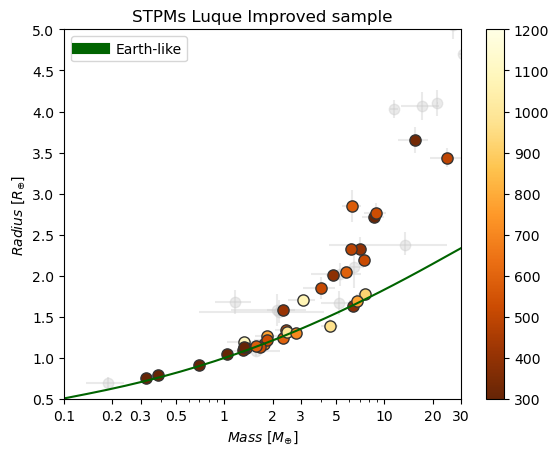

In [4]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
density = []; mass = []; radius = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        density.append(density_LI[i])
        mass.append(mass_LI[i])
        radius.append(radius_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("STPMs Luque Improved sample")

def find_planet(name):
    index = planet_name_LI.index(name)
    plt.plot(mass_LI[index],radius_LI[index],".", color = "blue")
    mass_err_LI_index   = [mass_unc_low_LI[index],mass_unc_up_LI[index]]
    radius_err_LI_index = [radius_unc_low_LI[index],radius_unc_up_LI[index]]
    plt.errorbar(mass_LI[index],radius_LI[index],fmt='.',markersize = 15,color = "blue",zorder=-32,alpha = 0.4)
    print(str(name) + " has a mass of " + str(mass_LI[index]) + " a radius of "+str(radius_LI[index]))


In [5]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()


In [10]:
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
index = []; index_rocky = []; index_water = []; index_puffy = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i]))  and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)


In [11]:
def transform_to_pc_basis(mass, radius, PC1, PC2):
    # Assuming mass and radius are single values
    data = np.array([mass, radius])
    transformation_matrix = np.array([PC1, PC2])
    transformed_data = np.dot(np.transpose(transformation_matrix), data)
    mass = transformed_data[0]
    radius = transformed_data[1]
    return mass, radius

index = []; index_rocky = []; index_water = []; index_puffy = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i]))  and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
            
PC1 = np.array([0.99091719, 0.13447347])
PC2 = np.array([0.13447347, -0.99091719])
mass   = list(mass_LI[index_rocky])+list(mass_LI[index_puffy])+list(mass_LI[index_water])
radius = list(radius_LI[index_rocky])+list(radius_LI[index_puffy])+list(radius_LI[index_water])

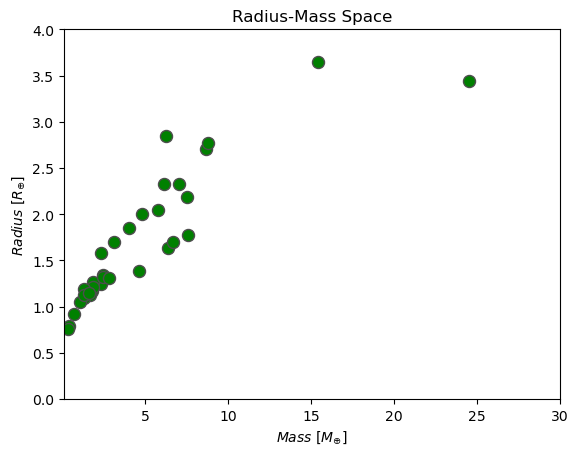

[[22.93531446  3.09660892]
 [ 3.09660892  0.53704186]]
[23.35554305  0.11681326]
[[ 0.99091719 -0.13447347]
 [ 0.13447347  0.99091719]]


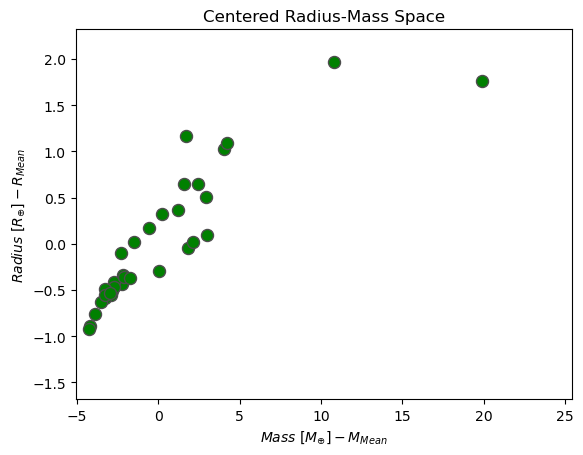

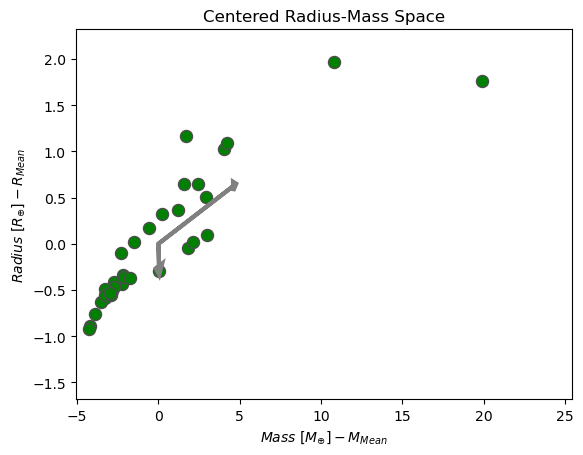

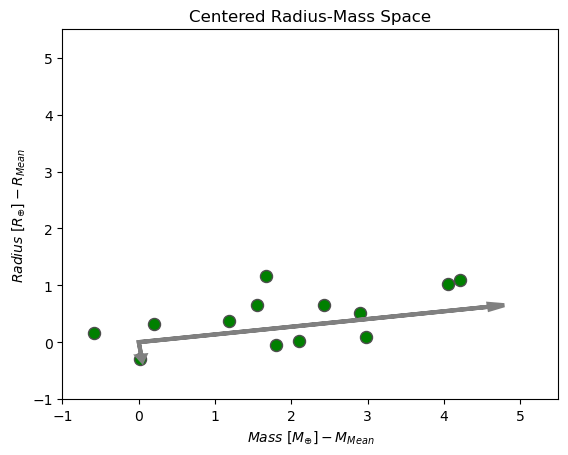

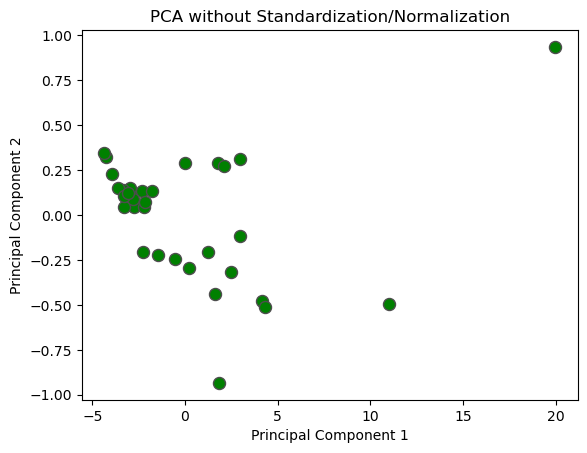

In [59]:
fig, ax = plt.subplots()
plt.scatter(data[:,0],data[:,1],s=75, color = "green",edgecolor = "0.3",zorder = -20)
plt.xlim(0.1, 30); plt.ylim(0, 4); 
#plt.xscale("log")
#plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$Radius \ [R_{\oplus}]$'); plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.title('Radius-Mass Space')
plt.show()
fig.savefig("PCA1", format="svg", dpi=1200)

fig, ax = plt.subplots()
data = np.column_stack((mass, radius))
mean_vector = np.mean(data, axis=0)
centered_data = data - mean_vector
plt.scatter(centered_data[:,0],centered_data[:,1],s=75, color = "green", edgecolor = "0.3")
plt.xlim(0-mean_vector[0]-0.5, 30-mean_vector[0]); plt.ylim(0-mean_vector[1], 4-mean_vector[1]); 
plt.ylabel('$Radius \ [R_{\oplus}] - R_{Mean}$'); plt.xlabel("$Mass\ [M_{\oplus}] - M_{Mean}$")
plt.title('Centered Radius-Mass Space')
fig.savefig("PCA2", format="svg", dpi=1200)

fig, ax = plt.subplots()
covariance_matrix = np.cov(centered_data, rowvar=False)
print(covariance_matrix)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print(eigenvalues)
print(eigenvectors)

plt.scatter(centered_data[:,0],centered_data[:,1],s=75, color = "green", edgecolor = "0.3")

scaled_PC1 = np.sqrt(eigenvalues[0]) * PC1
scaled_PC2 = np.sqrt(eigenvalues[1]) * PC2

plt.arrow(0, 0,scaled_PC1[0],scaled_PC1[1] ,length_includes_head = True,lw = 3,head_width=0.1, head_length=0.2, fc='0.5', ec='0.5', label='Scaled PC2')
plt.arrow(0, 0,scaled_PC2[0],scaled_PC2[1] ,length_includes_head = True,lw = 3, head_width=0.4, head_length=0.1, fc='0.5', ec='0.5', label='Scaled PC2')
plt.xlim(0-mean_vector[0]-0.5, 30-mean_vector[0]); plt.ylim(0-mean_vector[1], 4-mean_vector[1]); 
plt.ylabel('$Radius \ [R_{\oplus}] - R_{Mean}$'); plt.xlabel("$Mass\ [M_{\oplus}] - M_{Mean}$")
plt.title('Centered Radius-Mass Space')
fig.savefig("PCA3", format="svg", dpi=1200)


fig, ax = plt.subplots()
plt.scatter(centered_data[:,0],centered_data[:,1],s=75, color = "green", edgecolor = "0.3")

scaled_PC1 = np.sqrt(eigenvalues[0]) * PC1
scaled_PC2 = np.sqrt(eigenvalues[1]) * PC2

plt.arrow(0, 0,scaled_PC1[0],scaled_PC1[1] ,length_includes_head = True,lw = 3,head_width=0.1, head_length=0.2, fc='0.5', ec='0.5', label='Scaled PC2')
plt.arrow(0, 0,scaled_PC2[0],scaled_PC2[1] ,length_includes_head = True,lw = 3, head_width=0.1, head_length=0.1, fc='0.5', ec='0.5', label='Scaled PC2')
plt.xlim(-1,5.5); plt.ylim(-1,5.5); 
plt.ylabel('$Radius \ [R_{\oplus}] - R_{Mean}$'); plt.xlabel("$Mass\ [M_{\oplus}] - M_{Mean}$")
plt.title('Centered Radius-Mass Space')
fig.savefig("PCA4", format="svg", dpi=1200)


fig, ax = plt.subplots()
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
k = 2
top_k_eigenvectors = eigenvectors[:, :k]
projected_data = np.dot(centered_data, [PC1,PC2])
plt.scatter(projected_data[:, 0], projected_data[:, 1],s=75,color = "green", edgecolor = "0.3")
plt.title('PCA without Standardization/Normalization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')               
fig.savefig("PC5", format="svg", dpi=1200)


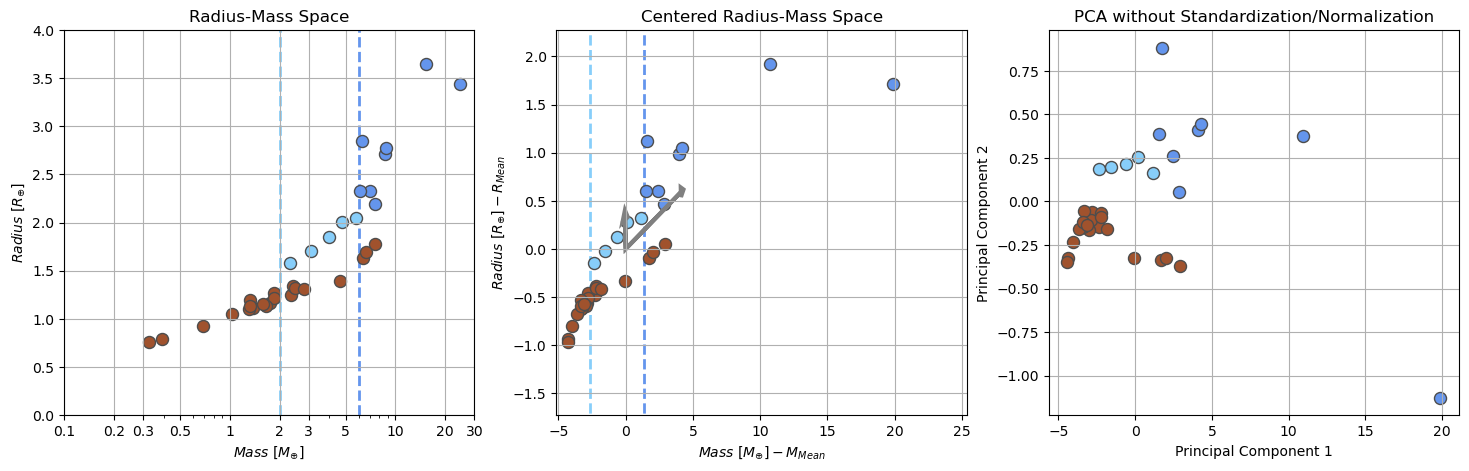

In [328]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'mass' and 'radius' lists defined
# ...

fig, ax = plt.subplots(figsize=(18, 5))

data = np.column_stack((mass, radius))
mean_vector = np.mean(data, axis=0)
centered_data = data - mean_vector
covariance_matrix = np.cov(centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
k = 2
top_k_eigenvectors = eigenvectors[:, :k]
projected_data = np.dot(centered_data, top_k_eigenvectors)

data_rocky = np.column_stack((mass_LI[index_rocky], radius_LI[index_rocky])) - mean_vector
projected_data_rocky = np.dot(data_rocky, top_k_eigenvectors)
data_water = np.column_stack((mass_LI[index_water], radius_LI[index_water])) - mean_vector
projected_data_water = np.dot(data_water, top_k_eigenvectors)
data_puffy = np.column_stack((mass_LI[index_puffy], radius_LI[index_puffy])) - mean_vector
projected_data_puffy = np.dot(data_puffy, top_k_eigenvectors)

plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
plt.grid(zorder=-32)

plt.scatter(mass_LI[index_rocky], radius_LI[index_rocky], color="Sienna", s=75, edgecolor="0.3")
plt.scatter(mass_LI[index_water], radius_LI[index_water], color="lightskyblue", s=75, edgecolor="0.3")
plt.scatter(mass_LI[index_puffy], radius_LI[index_puffy], color="cornflowerblue", s=75, edgecolor="0.3")

plt.vlines(2, 0, 20, colors="lightskyblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.vlines(6, 0, 20, colors="cornflowerblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.xlim(0.1, 30)
plt.ylim(0, 4)
plt.xscale("log")
plt.xticks([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30], ["0.1", "0.2", "0.3", "0.5", "1", "2", "3", "5", "10", "20", "30"],
           minor=False)
plt.ylabel('$Radius \ [R_{\oplus}]$')
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.title('Radius-Mass Space')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
plt.grid(zorder=-32)
plt.scatter(mass_LI[index_rocky] - mean_vector[0], radius_LI[index_rocky] - mean_vector[1], color="Sienna", s=75,
            edgecolor="0.3")
plt.scatter(mass_LI[index_water] - mean_vector[0], radius_LI[index_water] - mean_vector[1], color="lightskyblue", s=75,
            edgecolor="0.3")
plt.scatter(mass_LI[index_puffy] - mean_vector[0], radius_LI[index_puffy] - mean_vector[1], color="cornflowerblue", s=75,
            edgecolor="0.3")
scaled_PC1 = np.sqrt(eigenvalues[0]) * top_k_eigenvectors[:, 0]
scaled_PC2 = np.sqrt(eigenvalues[1]) * top_k_eigenvectors[:, 1]

plt.arrow(0, 0, scaled_PC1[0], scaled_PC1[1], length_includes_head=True, lw=3, head_width=0.1, head_length=0.2,
          fc='0.5', ec='0.5', label='Scaled PC1')
plt.arrow(0, 0, scaled_PC2[0], scaled_PC2[1], length_includes_head=True, lw=3, head_width=0.4, head_length=0.1,
          fc='0.5', ec='0.5', label='Scaled PC2')
plt.vlines(2 - mean_vector[0], -4, 20, colors="lightskyblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.vlines(6 - mean_vector[0], -4, 20, colors="cornflowerblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.xlim(0 - mean_vector[0] - 0.5, 30 - mean_vector[0])
plt.ylim(0 - mean_vector[1], 4 - mean_vector[1])
plt.ylabel('$Radius \ [R_{\oplus}] - R_{Mean}$')
plt.xlabel("$Mass\ [M_{\oplus}] - M_{Mean}$")
plt.title('Centered Radius-Mass Space')

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot
plt.scatter(projected_data_rocky[:, 0], projected_data_rocky[:, 1], color="Sienna", s=75, edgecolor="0.3")
plt.scatter(projected_data_water[:, 0], projected_data_water[:, 1], color="lightskyblue", s=75, edgecolor="0.3")
plt.scatter(projected_data_puffy[:, 0], projected_data_puffy[:, 1], color="cornflowerblue", s=75, edgecolor="0.3")

plt.title('PCA without Standardization/Normalization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(zorder=-32)
fig.savefig("PCA_simple.png", format="png", dpi=1200)
plt.show()


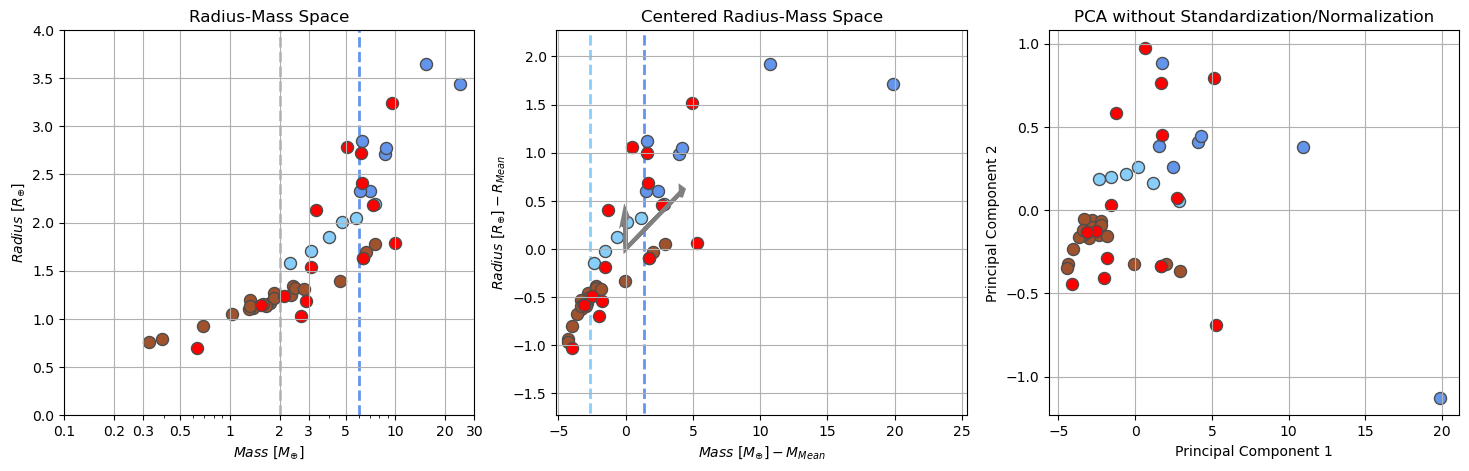

In [438]:
mass = np.concatenate((mass2,mass_LI[index_rocky],mass_LI[index_puffy],mass_LI[index_water]))
radius = np.concatenate((radius2,radius_LI[index_rocky],radius_LI[index_puffy],radius_LI[index_water]))
fig, ax = plt.subplots(figsize=(18, 5))
data = np.column_stack((mass, radius))
mean_vector = np.mean(data, axis=0)
centered_data = data - mean_vector
covariance_matrix = np.cov(centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
k = 2
top_k_eigenvectors = eigenvectors[:, :k]
projected_data = np.dot(centered_data, top_k_eigenvectors)

data_rocky = np.column_stack((mass_LI[index_rocky], radius_LI[index_rocky])) - mean_vector
projected_data_rocky = np.dot(data_rocky, top_k_eigenvectors)
data_water = np.column_stack((mass_LI[index_water], radius_LI[index_water])) - mean_vector
projected_data_water = np.dot(data_water, top_k_eigenvectors)
data_puffy = np.column_stack((mass_LI[index_puffy], radius_LI[index_puffy])) - mean_vector
projected_data_puffy = np.dot(data_puffy, top_k_eigenvectors)
data_new = np.column_stack((mass2, radius2)) - mean_vector
projected_data_new = np.dot(data_new, top_k_eigenvectors)

plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
plt.grid(zorder=-32)

plt.scatter(mass_LI[index_rocky], radius_LI[index_rocky], color="Sienna", s=75, edgecolor="0.3")
plt.scatter(mass_LI[index_water], radius_LI[index_water], color="lightskyblue", s=75, edgecolor="0.3")
plt.scatter(mass_LI[index_puffy], radius_LI[index_puffy], color="cornflowerblue", s=75, edgecolor="0.3")
plt.scatter(mass2, radius2, color="red", s=75, edgecolor="0.3")
plt.vlines(2, 0, 20, colors="lightskyblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.vlines(6, 0, 20, colors="cornflowerblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.xlim(0.1, 30)
plt.ylim(0, 4)
plt.xscale("log")
plt.xticks([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30], ["0.1", "0.2", "0.3", "0.5", "1", "2", "3", "5", "10", "20", "30"],
           minor=False)
plt.ylabel('$Radius \ [R_{\oplus}]$')
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.title('Radius-Mass Space')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
plt.grid(zorder=-32)
plt.scatter(mass_LI[index_rocky] - mean_vector[0], radius_LI[index_rocky] - mean_vector[1], color="Sienna", s=75,
            edgecolor="0.3")
plt.scatter(mass_LI[index_water] - mean_vector[0], radius_LI[index_water] - mean_vector[1], color="lightskyblue", s=75,
            edgecolor="0.3")
plt.scatter(mass_LI[index_puffy] - mean_vector[0], radius_LI[index_puffy] - mean_vector[1], color="cornflowerblue", s=75,
            edgecolor="0.3")
plt.scatter(mass2 - mean_vector[0], radius2 - mean_vector[1], color="red", s=75,
            edgecolor="0.3")
scaled_PC1 = np.sqrt(eigenvalues[0]) * top_k_eigenvectors[:, 0]
scaled_PC2 = np.sqrt(eigenvalues[1]) * top_k_eigenvectors[:, 1]

plt.arrow(0, 0, scaled_PC1[0], scaled_PC1[1], length_includes_head=True, lw=3, head_width=0.1, head_length=0.2,
          fc='0.5', ec='0.5', label='Scaled PC1')
plt.arrow(0, 0, scaled_PC2[0], scaled_PC2[1], length_includes_head=True, lw=3, head_width=0.4, head_length=0.1,
          fc='0.5', ec='0.5', label='Scaled PC2')
plt.vlines(2 - mean_vector[0], -4, 20, colors="lightskyblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.vlines(6 - mean_vector[0], -4, 20, colors="cornflowerblue", linestyle="dashed", zorder=-32, linewidth=2)
plt.xlim(0 - mean_vector[0] - 0.5, 30 - mean_vector[0])
plt.ylim(0 - mean_vector[1], 4 - mean_vector[1])
plt.ylabel('$Radius \ [R_{\oplus}] - R_{Mean}$')
plt.xlabel("$Mass\ [M_{\oplus}] - M_{Mean}$")
plt.title('Centered Radius-Mass Space')

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot
plt.scatter(projected_data_rocky[:, 0], projected_data_rocky[:, 1], color="Sienna", s=75, edgecolor="0.3")
plt.scatter(projected_data_water[:, 0], projected_data_water[:, 1], color="lightskyblue", s=75, edgecolor="0.3")
plt.scatter(projected_data_puffy[:, 0], projected_data_puffy[:, 1], color="cornflowerblue", s=75, edgecolor="0.3")
plt.scatter(projected_data_new[:, 0], projected_data_new[:, 1], color="red", s=75, edgecolor="0.3")

mass_ready = np.concatenate((projected_data_rocky[:, 0],projected_data_water[:, 0],projected_data_puffy[:, 0],projected_data_new[:, 0]))
radius_ready = np.concatenate((projected_data_rocky[:, 1],projected_data_water[:, 1],projected_data_puffy[:, 1],projected_data_new[:, 1]))

plt.title('PCA without Standardization/Normalization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(zorder=-32)
#fig.savefig("PCA_simple_new.png", format="png", dpi=1200)
plt.show()


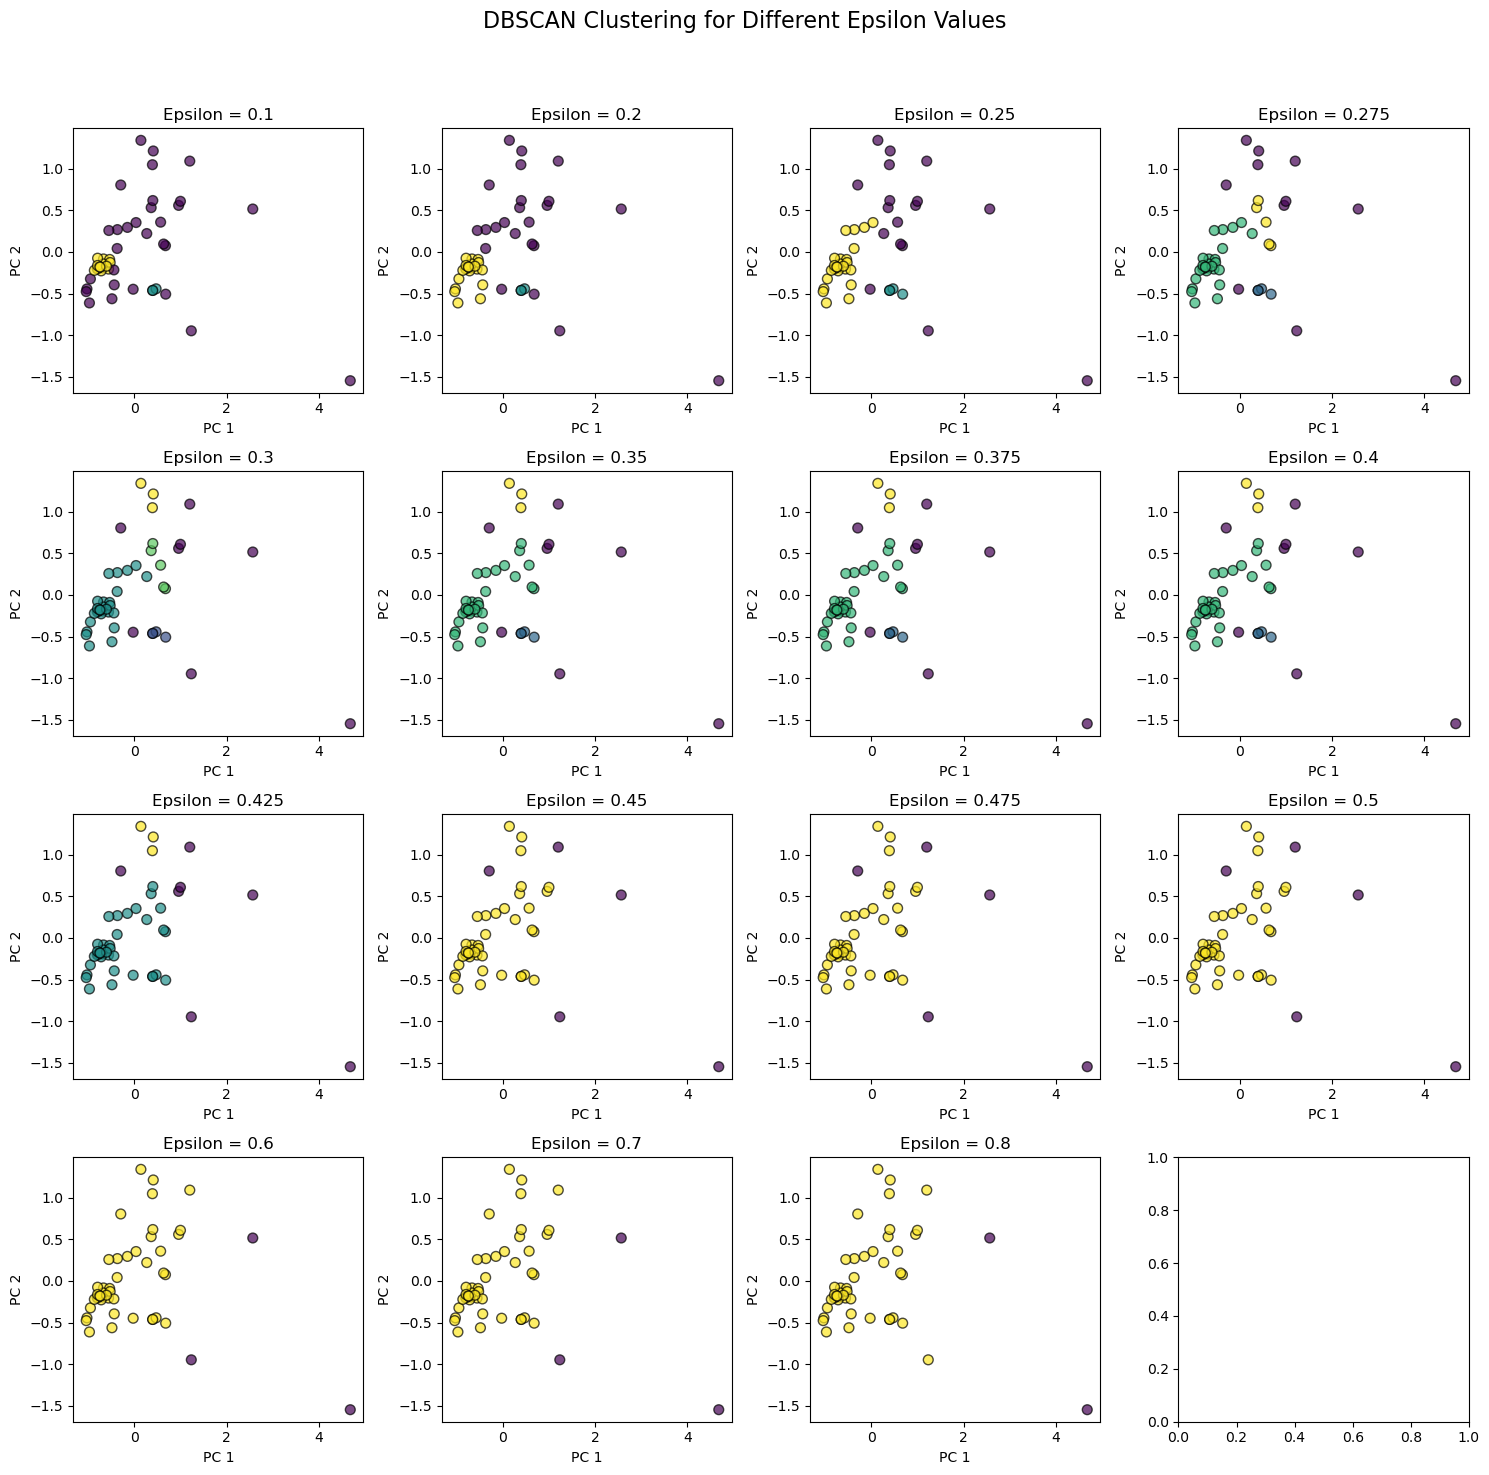

In [427]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Assuming you have masses and radii defined somewhere
data = np.transpose([mass_ready/np.std(mass), radius_ready/np.std(radius)])

# Define a list of epsilon values
isss = [0.1, 0.2,0.25,0.275, 0.3,0.35,0.375, 0.4, 0.425,0.45,0.475,0.5, 0.6, 0.7, 0.8]

# Create a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.suptitle('DBSCAN Clustering for Different Epsilon Values', fontsize=16)

# Iterate through epsilon values and plot on each subplot
for i, eps in enumerate(isss):
    row = i // 4
    col = i % 4

    # Fit DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan.fit(data)

    # Plot the clustered data and outliers
    axes[row, col].scatter(data[:, 0], data[:, 1], c=dbscan.labels_, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
    axes[row, col].set_title(f'Epsilon = {eps}')
    axes[row, col].set_xlabel('PC 1')
    axes[row, col].set_ylabel('PC 2')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("PCA_DSSCAN_new.png", format="png", dpi=1200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


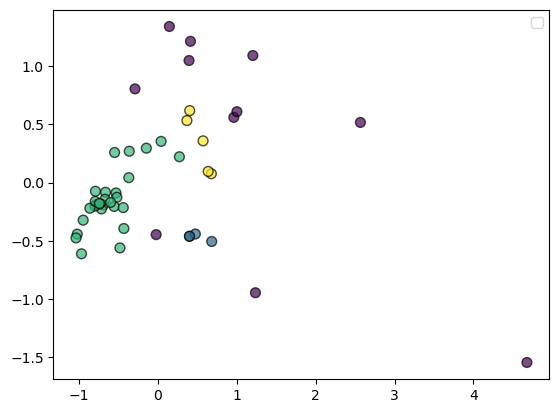

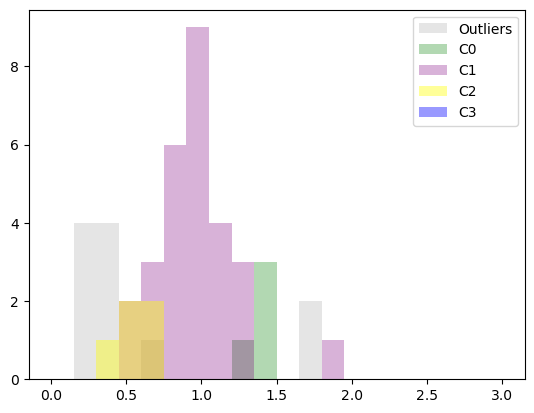

In [479]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

data = np.transpose([mass_ready/np.std(mass), radius_ready/np.std(radius)])
mass_all = np.concatenate((mass_rocky,mass_water,mass_puffy,mass2))
radius_all = np.concatenate((radius_rocky,radius_water,radius_puffy,radius2))
density_all = np.concatenate((density_rocky,density_water,density_puffy,density2))

isss = [0.1, 0.2,0.25,0.275, 0.3,0.35,0.375, 0.4, 0.425,0.45,0.475,0.5, 0.6, 0.7, 0.8]
dbscan = DBSCAN(eps=0.275, min_samples=3)
dbscan.fit(data)
dbscan_labels = dbscan.labels_ 
plt.scatter(data[:, 0], data[:, 1], c=dbscan.labels_, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
bins = np.linspace(0, 3, 21)
plt.legend()

plt.show()
outlier = []; c0 = []; c1 = []; c2 = []; c3 = []; 
for i in range(0,len(density_all)):
    if dbscan_labels[i] == -1:
        outlier.append(density_all[i])
    if dbscan_labels[i] == 0:
        c0.append(density_all[i])
    if dbscan_labels[i] == 1:
        c1.append(density_all[i])
    if dbscan_labels[i] == 2:
        c2.append(density_all[i])
    if dbscan_labels[i] == 3:
        c3.append(density_all[i])
    if dbscan_labels[i] == 4:
        c4.append(density_all[i])
plt.hist(outlier/earth_density,bins=bins, color='gray', alpha=0.2, label='Outliers',density=False)
plt.hist(c0/earth_density,bins=bins, color='green', alpha=0.3, label='C0',density=False)
plt.hist(c1/earth_density,bins=bins, color='purple', alpha=0.3, label='C1',density=False)
plt.hist(c2/earth_density,bins=bins, color='yellow', alpha=0.4, label='C2',density=False)
plt.hist(c3/earth_density,bins=bins, color='blue', alpha=0.4, label='C3',density=False)

plt.hist
plt.legend()

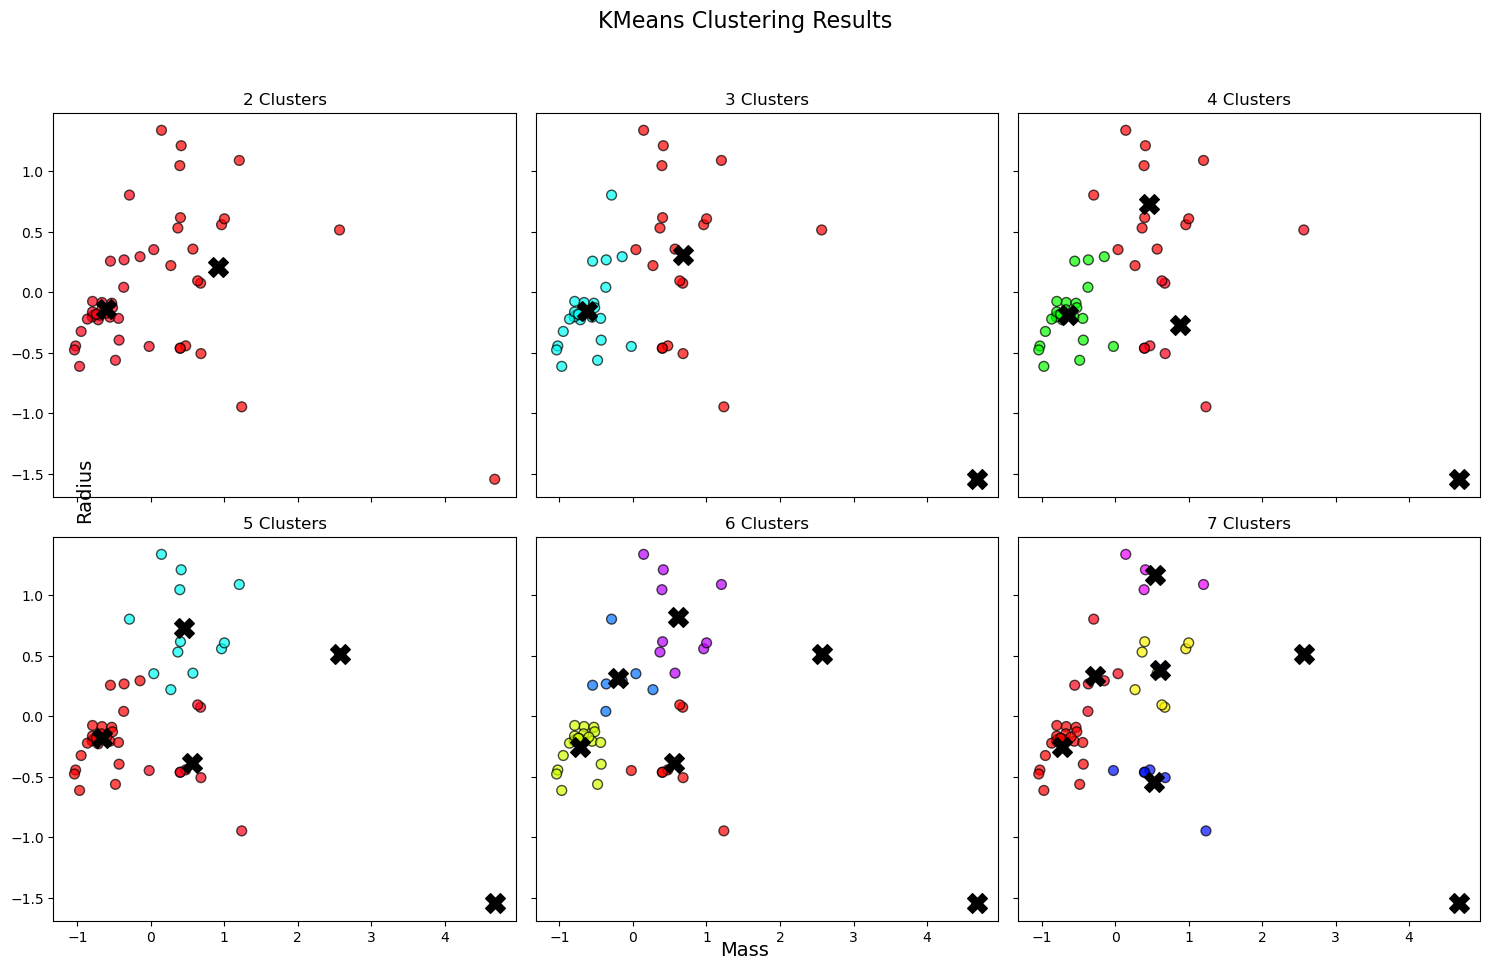

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = np.transpose([mass_ready/np.std(mass), radius_ready/np.std(radius)])

# Define the number of clusters
num_clusters = range(2, 8)

# Create a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Loop over different numbers of clusters
for i, n_clusters in enumerate(num_clusters):
    # Fit K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)

    # Plot the clustered data and centroids in each subplot
    axs[i].scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='hsv', edgecolors='k', s=50, alpha=0.7)
    axs[i].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
    axs[i].set_title(f'{n_clusters} Clusters')

# Set common labels
fig.suptitle('KMeans Clustering Results', fontsize=16)
fig.text(0.5, 0.04, 'Mass', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Radius', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("PCA_Kmeans_new.png", format="png", dpi=1200)


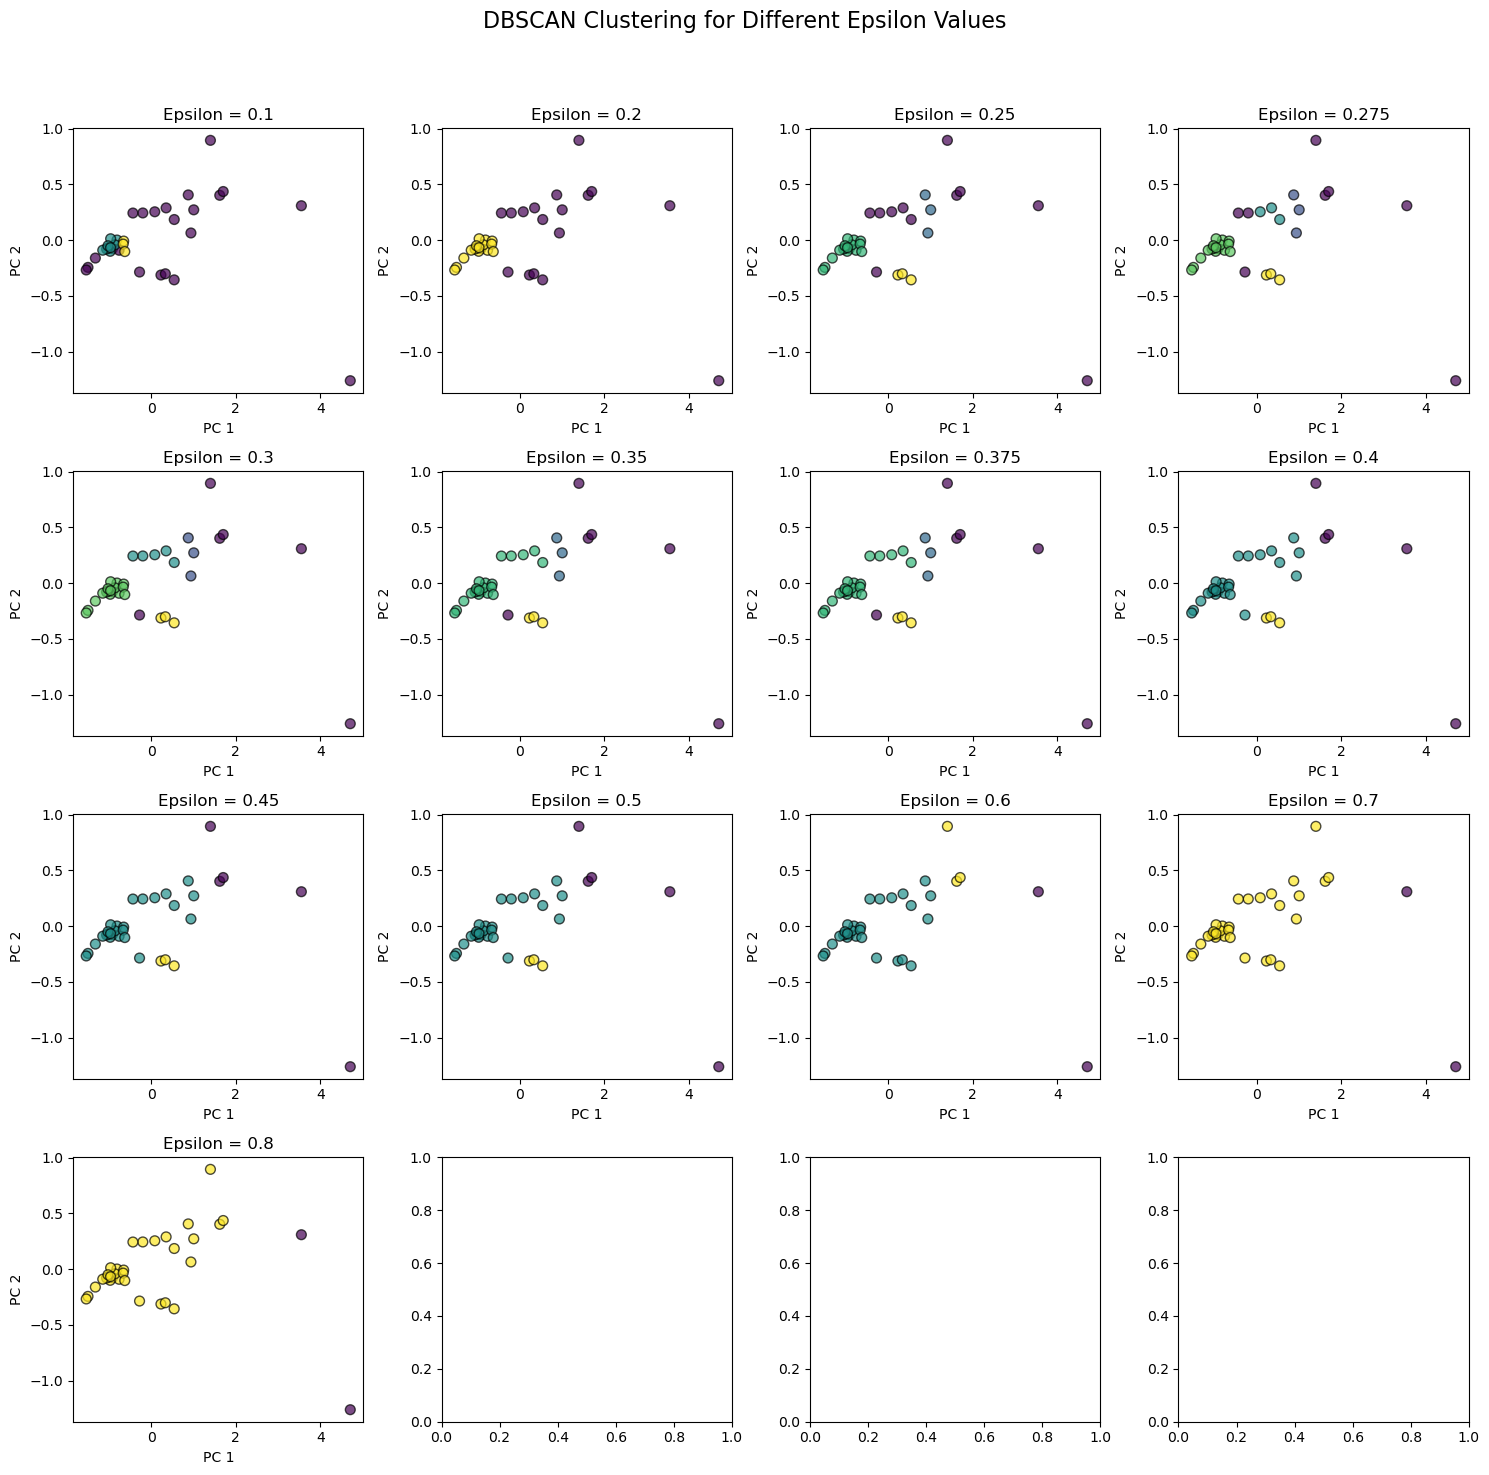

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Assuming you have masses and radii defined somewhere
data = np.transpose([mass_ready, radius_ready])

# Define a list of epsilon values
isss = [0.1, 0.2,0.25,0.275, 0.3,0.35,0.375, 0.4, 0.45,0.5, 0.6, 0.7, 0.8]

# Create a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.suptitle('DBSCAN Clustering for Different Epsilon Values', fontsize=16)

# Iterate through epsilon values and plot on each subplot
for i, eps in enumerate(isss):
    row = i // 4
    col = i % 4

    # Fit DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan.fit(data)

    # Plot the clustered data and outliers
    axes[row, col].scatter(data[:, 0], data[:, 1], c=dbscan.labels_, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
    axes[row, col].set_title(f'Epsilon = {eps}')
    axes[row, col].set_xlabel('PC 1')
    axes[row, col].set_ylabel('PC 2')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
#fig.savefig("PCA_DSSCAN.png", format="png", dpi=1200)


In [392]:
PC1 = np.array([0.99091719, 0.13447347])
PC2 = np.array([0.13447347, -0.99091719])

eigenvalues = np.array([eigenvalues[i] for i in sorted_indices])
scaled_PC1 = np.sqrt(eigenvalues[0]) * PC1
scaled_PC2 = np.sqrt(eigenvalues[1]) * PC2

plt.arrow(0,0, scaled_PC1[0], scaled_PC1[1], head_width=0.05, head_length=0.1, fc='red', ec='red', label='Scaled PC1')
plt.arrow(0,0, scaled_PC2[0], scaled_PC2[1], head_width=0.05, head_length=0.1, fc='blue', ec='blue', label='Scaled PC2')

plt.title('Principal Components (Scaled by Square Root of Eigenvalues)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.grid(True)
plt.show()

7

In [352]:
density_norm = density_LI / earth_density

mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
  
index = []
mass_rocky = []; mass_water = []; mass_puffy = [];
radius_rocky = []; radius_water = []; radius_puffy = [];
density_rocky = []; density_water = []; density_puffy = [];
density_low_rocky =[]; density_low_water = []; density_low_puffy = []
density_up_rocky =[]; density_up_water = []; density_up_puffy = []
planet_rocky = []; planet_water = []; planet_puffy = []
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
            mass_rocky.append(mass_LI[i])
            radius_rocky.append(radius_LI[i])
            density_rocky.append(density_LI[i])
            density_low_rocky.append(density_unc_low_LI[i])
            density_up_rocky.append(density_unc_up_LI[i])
            planet_rocky.append(planet_name_LI[i])
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i]))  and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
            mass_puffy.append(mass_LI[i])
            radius_puffy.append(radius_LI[i])
            density_puffy.append(density_LI[i])
            density_low_puffy.append(density_unc_low_LI[i])
            density_up_puffy.append(density_unc_up_LI[i])
            planet_puffy.append(planet_name_LI[i])
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
            mass_water.append(mass_LI[i])
            radius_water.append(radius_LI[i])
            density_water.append(density_LI[i])
            density_low_water.append(density_unc_low_LI[i])
            density_up_water.append(density_unc_up_LI[i])
            planet_water.append(planet_name_LI[i])


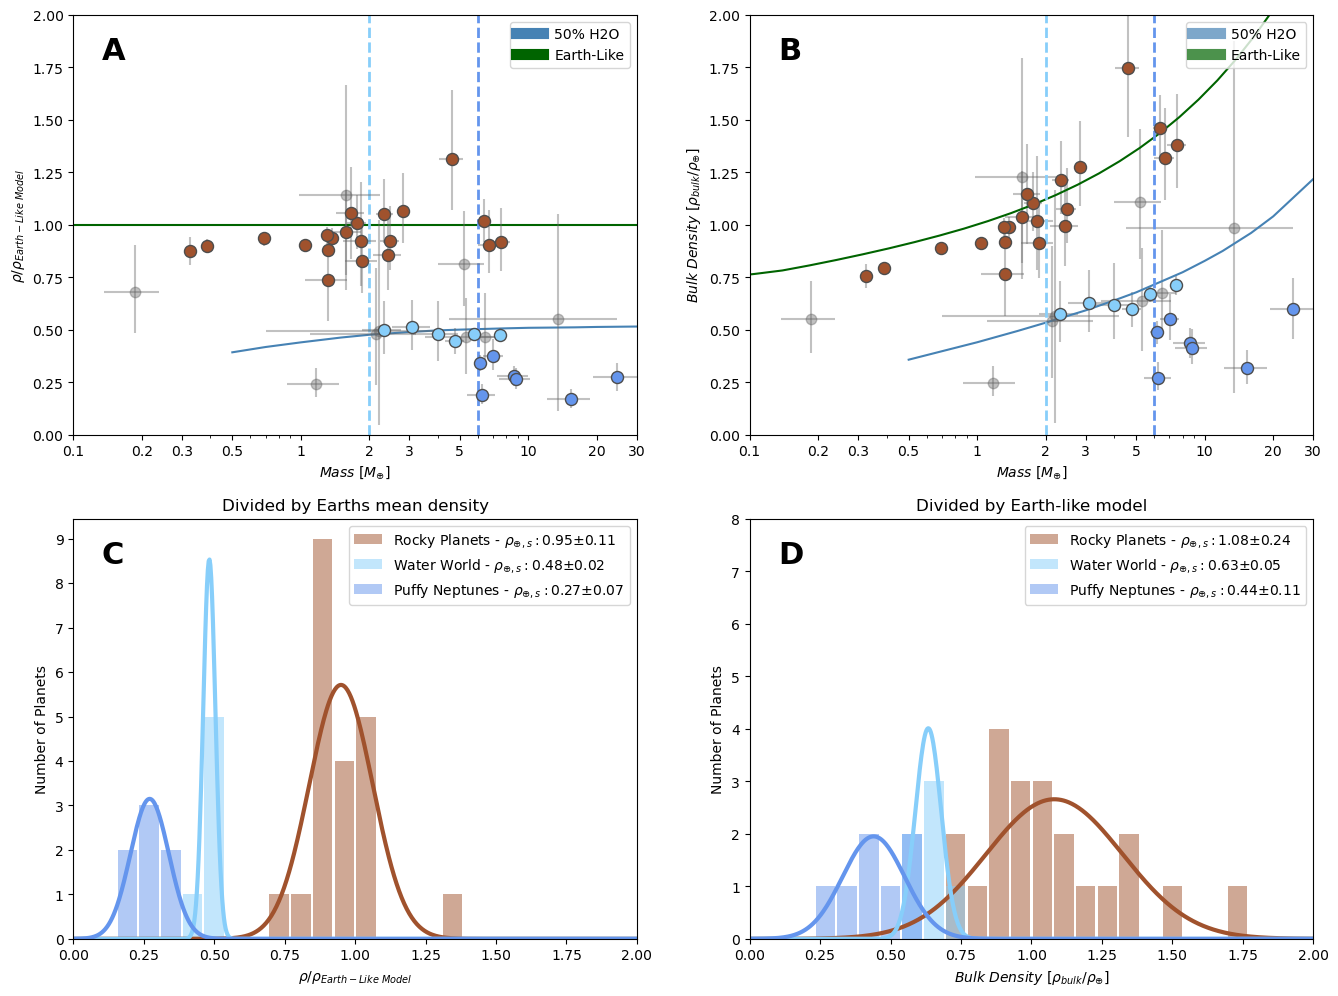

In [491]:
bins  = np.linspace(0, 3, 40)
import matplotlib.pyplot as plt
import numpy as np
# Plot the lines
fig, ax = plt.subplots(figsize=(16,12))
for i, label in enumerate(('A', 'B',"C","D")):
    ax = fig.add_subplot(2,2,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(2, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
index = []; index_rocky = []; index_water = []; index_puffy = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i]))  and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)

plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.xlabel("$Mass\ [M_{\oplus}]$")

plt.subplot(2, 2, 2)  # 1 row, 2 columns, first subplot
plt.scatter(mass_rocky,density_rocky/earth_density,color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_puffy,density_puffy/earth_density,color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_water,density_water/earth_density,color = "lightskyblue",s = 75, edgecolor = "0.3")

xerr = [mass_unc_low_LI, mass_unc_up_LI]
yerr = [density_unc_low_LI/earth_density,density_unc_up_LI/earth_density]
for i in range(0,len(mass_LI)):
    if radius_LI[i]< 4:
        plt.errorbar(mass_LI[i], density_LI[i]/earth_density, xerr=[[xerr[0][i]],[xerr[1][i]]] , yerr=[[yerr[0][i]],[yerr[1][i]]],fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)


earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 


plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3/earth_density, "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3/earth_density, "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")

leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.xlabel("$Mass\ [M_{\oplus}]$")



plt.subplot(2, 2, 3)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 3, 40)
pbins = np.linspace(0, 3, 1000)

###### Rocky Planets #####
indexs = index_rocky
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

###### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water World - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "cornflowerblue",linewidth=3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, label="Puffy Neptunes - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)), linewidth=3)

##### Plotting ######
plt.title('Divided by Earths mean density')
plt.ylabel('Number of Planets')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.yticks([0,1,2,3,4,5,6,7,8,9],["0","1","2","3","4","5","6","7","8","9"],minor=False)

plt.xlim(0,2)
plt.subplot(2, 2, 4)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs = index_rocky
hist_values_false, bin_edges, _ = plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_rocky/earth_density)
sigma = np.sqrt(np.cov(density_rocky/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

###### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_water/earth_density)
sigma = np.sqrt(np.cov(density_water/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water World - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_puffy/earth_density)
sigma = np.sqrt(np.cov(density_puffy/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "cornflowerblue",linewidth=3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, label="Puffy Neptunes - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)), linewidth=3)

##### Plotting ######
plt.ylabel('Number of Planets')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlim(0,2)
##### Plotting ######
plt.title('Divided by Earth-like model')
plt.ylabel('Number of Planets')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5,1.75,2],["0.00","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"],minor=False)
plt.yticks([0,1,2,3,4,5,6,7,8],["0","1","2","3","4","5","6","7","8"],minor=False)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlim(0,2)
image_name = 'Division_meaning.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

0.5526315789473685

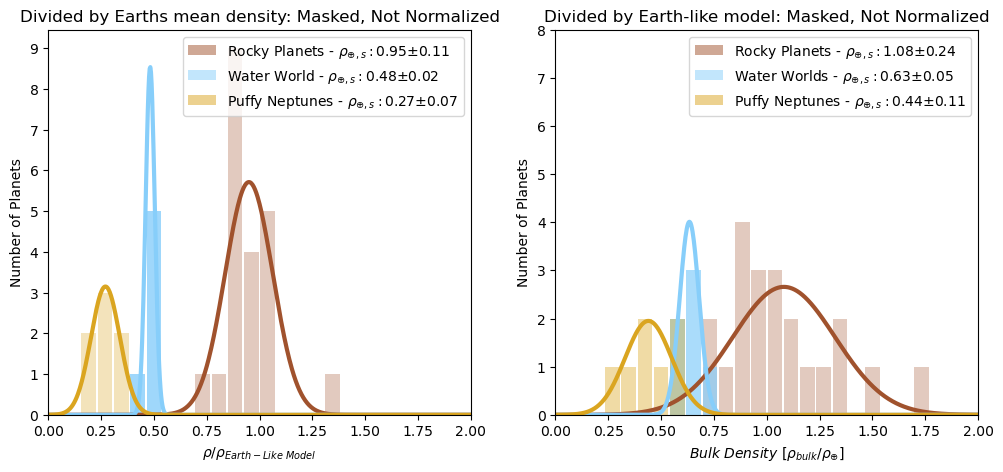

In [484]:
bins  = np.linspace(0, 3, 40)
pbins = np.linspace(0, 3, 1000)
fig, ax = plt.subplots(figsize=(12,5))
for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(2,1,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs = index_rocky
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.3, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

###### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.8, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water World - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='goldenrod', alpha=0.3, rwidth=0.9, density=False,zorder =-12)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "goldenrod",linewidth=3)
plt.hist(100, bins=bins, color='goldenrod', alpha=0.5, rwidth=0.9, density=True, label="Puffy Neptunes - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)), linewidth=3)

##### Plotting ######
plt.title('Divided by Earths mean density: Masked, Not Normalized')
plt.ylabel('Number of Planets')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.yticks([0,1,2,3,4,5,6,7,8,9],["0","1","2","3","4","5","6","7","8","9"],minor=False)

plt.xlim(0,2)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
hist_values_false, bin_edges, _ = plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.3, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_rocky/earth_density)
sigma = np.sqrt(np.cov(density_rocky/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.7, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_water/earth_density)
sigma = np.sqrt(np.cov(density_water/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_puffy/earth_density, bins=bins, color='goldenrod', alpha=0.4, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_puffy/earth_density)
sigma = np.sqrt(np.cov(density_puffy/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "goldenrod",linewidth=3)
plt.hist(100, bins=bins, color='goldenrod',alpha = 0.5, rwidth=0.9, density=True,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Plotting ######
plt.title('Divided by Earth-like model: Masked, Not Normalized')
plt.ylabel('Number of Planets')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5,1.75,2],["0.00","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"],minor=False)
plt.yticks([0,1,2,3,4,5,6,7,8],["0","1","2","3","4","5","6","7","8"],minor=False)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlim(0,2)
plt.show()
image_name = 'Histograms_Division_meaning.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

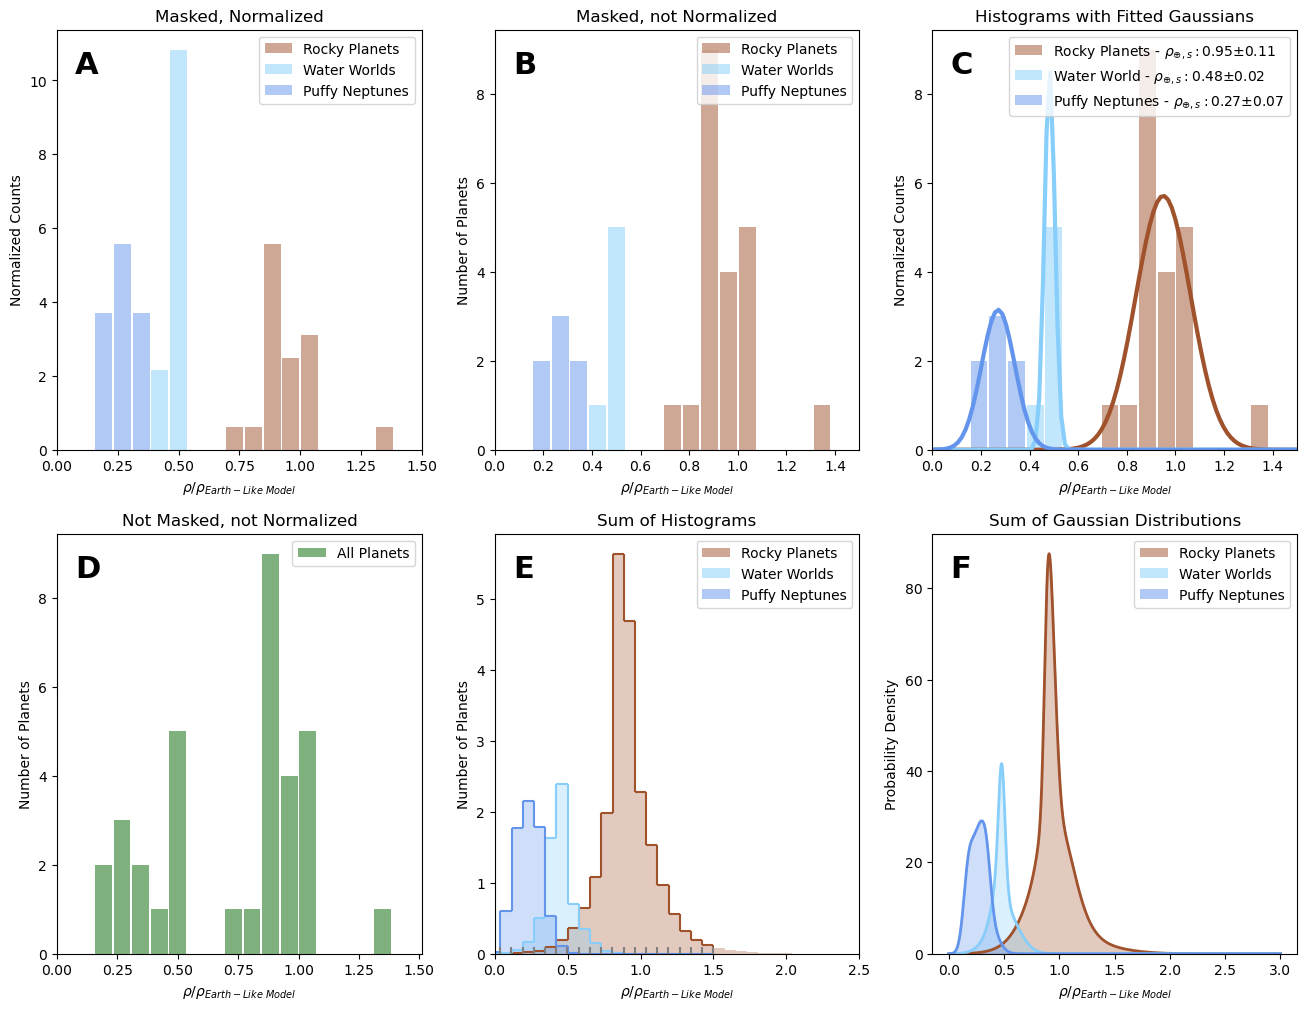

In [486]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(16,12))
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

for i, label in enumerate(('A', 'B', 'C', 'D','E',"F")):
    ax = fig.add_subplot(2,3,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(2, 3, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 3, 40)
pbins = np.linspace(0, 1.5, 100)
###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)


plt.subplot(2, 3, 2)
###### Rocky Planets #####
indexs = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, not Normalized')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel("Number of Planets")
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)
    line.set_alpha(0.7)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(2, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs = index_rocky
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

###### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water World - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "cornflowerblue",linewidth=3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, label="Puffy Neptunes - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)), linewidth=3)

##### Plotting ######
plt.title('Histograms with Fitted Gaussians')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(2, 3, 4)  # 1 row, 2 columns, first subplot
###### ALL Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False,label = "All Planets")
plt.title('Not Masked, not Normalized')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel("Number of Planets")
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.51)
plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)


plt.subplot(2, 3, 5)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 3, 40)
total_height_rocky  = np.zeros(len(bins)-1)
indexs = index_rocky
for i in range(0,len(planet_rocky)):
    mean = density_norm[indexs[i]]
    std_dev_upper = density_err_LI[0][indexs[i]]
    std_dev_lower = density_err_LI[1][indexs[i]]

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_rocky += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

for i in range(0,20):
    plt.vlines(bin_edges[i]+intv/2,0,0.01,"0.4")
for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_rocky[i],total_height_rocky[i+1],"sienna")
    plt.hlines(total_height_rocky[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,"sienna")
plt.vlines(bin_edges[19]+intv/2,0,total_height_rocky[19],"sienna")
plt.hlines(total_height_rocky[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,"sienna")

plt.bar(bin_edges[:-1],total_height_rocky, width=bin_edges[1] - bin_edges[0], alpha=0.3,color = "sienna",zorder = -21)
plt.hist(100, bins=bins, color='sienna', alpha=0.5,rwidth=0.9, density=True,label = "Rocky Planets")

total_height_water  = np.zeros(len(bins)-1)
indexs = index_water
for i in range(0,len(planet_water)):
    mean = density_norm[indexs[i]]
    std_dev_upper = density_err_LI[0][indexs[i]]
    std_dev_lower = density_err_LI[1][indexs[i]]

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_water += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_water, width=bin_edges[1] - bin_edges[0], alpha=0.3,color= 'lightskyblue',zorder = -21)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

intv = bin_edges[1]-bin_edges[0]
for i in range(0,20):
    plt.vlines(bin_edges[i]+intv/2,0,0.01,"0.4")
for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_water[i],total_height_water[i+1],"lightskyblue")
    plt.hlines(total_height_water[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,"lightskyblue")
plt.vlines(bin_edges[19]+intv/2,0,total_height_water[19],"lightskyblue")
plt.hlines(total_height_water[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,"lightskyblue")
indexs = index_puffy

total_height_puffy  = np.zeros(len(bins)-1)
for i in range(0,len(planet_puffy)):
    mean = density_norm[indexs[i]]
    std_dev_upper = density_err_LI[0][indexs[i]]
    std_dev_lower = density_err_LI[1][indexs[i]]

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_puffy += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_puffy, width=bin_edges[1] - bin_edges[0], alpha=0.3,color= 'cornflowerblue',zorder = -21)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_puffy[i],total_height_puffy[i+1],'cornflowerblue')
    plt.hlines(total_height_puffy[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,'cornflowerblue')
plt.vlines(bin_edges[19]+intv/2,0,total_height_puffy[19],'cornflowerblue')
plt.hlines(total_height_puffy[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,'cornflowerblue')

for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.1,"0.5",zorder = 10)
plt.xlabel("$ρ / ρ_{Earth-Like\ Model}$")
plt.ylabel("Number of Planets")
plt.title('Sum of Histograms')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlim(0,2.5)
plt.subplot(2, 3, 6)  # 1 row, 2 columns, first subplot
x = np.linspace(0, 3, 100000)
y_total = 0

indexs = index_rocky
for i in range(0,len(planet_rocky)):
    mu, sigma = density_norm[indexs[i]], (density_err_LI[0][indexs[i]] + density_err_LI[1][indexs[i]])/2
    y = norm.pdf(x, mu, sigma)
    #plt.plot(x, y,"Sienna",alpha = 0.3)
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "Sienna")
plt.fill_between(x, 0, y_total, color="Sienna", alpha=0.3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label='Rocky Planets')

indexs = index_water
y_total = 0
for i in range(0,len(planet_water)):
    mu, sigma = density_norm[indexs[i]], (density_err_LI[0][indexs[i]] + density_err_LI[1][indexs[i]])/2
    y = norm.pdf(x, mu, sigma,)
    #plt.plot(x, y,color = "lightskyblue",alpha = 0.5)
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "lightskyblue")
plt.fill_between(x, 0, y_total, color="lightskyblue", alpha=0.3 )
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label='Water Worlds')

y_total = 0
indexs = index_puffy
for i in range(0,len(planet_puffy)):
    mu, sigma = density_norm[indexs[i]], (density_err_LI[0][indexs[i]] + density_err_LI[1][indexs[i]])/2
    y = norm.pdf(x, mu, sigma)
    #plt.plot(x, y,"Cornflowerblue",alpha = 0.5,linestyle = "solid")
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "Cornflowerblue")
plt.fill_between(x, 0, y_total, color="Cornflowerblue", alpha=0.3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

plt.title('Sum of Gaussian Distributions')
plt.ylabel('Probability Density')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$ρ / ρ_{Earth-Like\ Model}$")
image_name = 'Histograms_Model.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


In [392]:
density_norm = density_LI / earth_density

mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
  
index = []
mass_rocky = []; mass_water = []; mass_puffy = [];
radius_rocky = []; radius_water = []; radius_puffy = [];
density_rocky = []; density_water = []; density_puffy = [];
density_low_rocky =[]; density_low_water = []; density_low_puffy = []
density_up_rocky =[]; density_up_water = []; density_up_puffy = []
planet_rocky = []; planet_water = []; planet_puffy = []
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
            mass_rocky.append(mass_LI[i])
            radius_rocky.append(radius_LI[i])
            density_rocky.append(density_LI[i])
            density_low_rocky.append(density_unc_low_LI[i])
            density_up_rocky.append(density_unc_up_LI[i])
            planet_rocky.append(planet_name_LI[i])
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i]))  and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
            mass_puffy.append(mass_LI[i])
            radius_puffy.append(radius_LI[i])
            density_puffy.append(density_LI[i])
            density_low_puffy.append(density_unc_low_LI[i])
            density_up_puffy.append(density_unc_up_LI[i])
            planet_puffy.append(planet_name_LI[i])
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
            mass_water.append(mass_LI[i])
            radius_water.append(radius_LI[i])
            density_water.append(density_LI[i])
            density_low_water.append(density_unc_low_LI[i])
            density_up_water.append(density_unc_up_LI[i])
            planet_water.append(planet_name_LI[i])


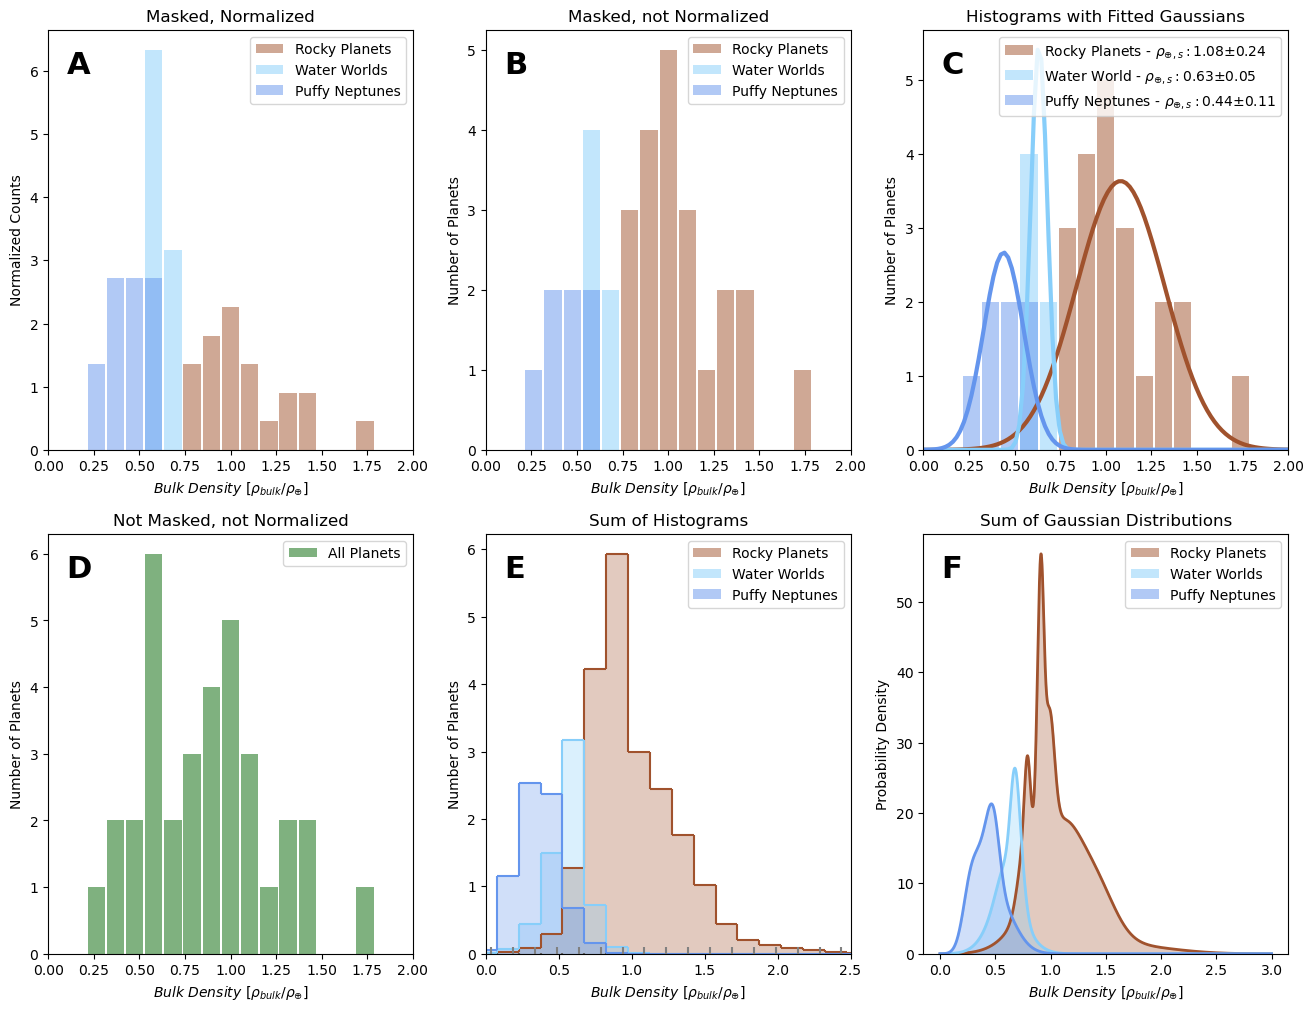

In [488]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(16,12))
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

for i, label in enumerate(('A', 'B', 'C', 'D','E',"F")):
    ax = fig.add_subplot(2,3,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(2, 3, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 2, 20)
pbins = np.linspace(0, 2, 100)
###### Rocky Planets #####
plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5,1.75,2],["0.00","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"],minor=False)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlim(0,2)

plt.subplot(2, 3, 2)
###### Rocky Planets #####
plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False,label = "Rocky Planets")

##### Water Worlds #####
plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False,label = "Water Worlds")

##### Puffy Neptunes #####
plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, not Normalized')
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)
    line.set_alpha(0.7)
plt.xlim(0,2)
plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5,1.75,2],["0.00","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"],minor=False)
plt.subplot(2, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs = index_rocky
hist_values_false, bin_edges, _ = plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_rocky/earth_density)
sigma = np.sqrt(np.cov(density_rocky/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "sienna",linewidth=3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

###### Water Worlds #####
indexs  = index_water
hist_values_false, bin_edges, _ = plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_water/earth_density)
sigma = np.sqrt(np.cov(density_water/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "lightskyblue",linewidth=3)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label ="Water World - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

##### Puffy Neptunes #####
indexs  = index_puffy
hist_values_false, bin_edges, _ = plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(density_puffy/earth_density)
sigma = np.sqrt(np.cov(density_puffy/earth_density, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
plt.plot(pbins, best_fit_line,color = "cornflowerblue",linewidth=3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, label="Puffy Neptunes - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)), linewidth=3)

##### Plotting ######
plt.title('Histograms with Fitted Gaussians')
plt.ylabel('Number of Planets')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.xlim(0,2)


plt.subplot(2, 3, 4)  # 1 row, 2 columns, first subplot
###### ALL Planets #####
all_density  = np.concatenate([density_puffy/earth_density,density_rocky/earth_density, density_water/earth_density])
plt.hist(all_density, bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False,label = "All Planets")
plt.title('Not Masked, not Normalized')
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.xlim(0,2)
plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5,1.75,2],["0.00","0.25","0.50","0.75","1.00","1.25","1.50","1.75","2.00"],minor=False)

plt.subplot(2, 3, 5)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 3, 21)
total_height_rocky  = np.zeros(len(bins)-1)
for i in range(0,len(planet_rocky)):
    mean = density_rocky[i]/earth_density
    std_dev_upper = density_up_rocky[i]/earth_density
    std_dev_lower = density_low_rocky[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_rocky += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

for i in range(0,20):
    plt.vlines(bin_edges[i]+intv/2,0,0.01,"0.4")
for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_rocky[i],total_height_rocky[i+1],"sienna")
    plt.hlines(total_height_rocky[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,"sienna")
plt.vlines(bin_edges[19]+intv/2,0,total_height_rocky[19],"sienna")
plt.hlines(total_height_rocky[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,"sienna")

plt.bar(bin_edges[:-1],total_height_rocky, width=bin_edges[1] - bin_edges[0], alpha=0.3,color = "sienna",zorder = -21)
plt.hist(100, bins=bins, color='sienna', alpha=0.5,rwidth=0.9, density=True,label = "Rocky Planets")

total_height_water  = np.zeros(len(bins)-1)
for i in range(0,len(planet_water)):
    mean = density_water[i]/earth_density
    std_dev_upper = density_up_water[i]/earth_density
    std_dev_lower = density_low_water[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_water += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_water, width=bin_edges[1] - bin_edges[0], alpha=0.3,color= 'lightskyblue',zorder = -21)
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

intv = bin_edges[1]-bin_edges[0]
for i in range(0,20):
    plt.vlines(bin_edges[i]+intv/2,0,0.01,"0.4")
for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_water[i],total_height_water[i+1],"lightskyblue")
    plt.hlines(total_height_water[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,"lightskyblue")
plt.vlines(bin_edges[19]+intv/2,0,total_height_water[19],"lightskyblue")
plt.hlines(total_height_water[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,"lightskyblue")

total_height_puffy  = np.zeros(len(bins)-1)
for i in range(0,len(planet_puffy)):
    mean = density_puffy[i]/earth_density
    std_dev_upper = density_up_puffy[i]/earth_density
    std_dev_lower = density_low_puffy[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_puffy += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_puffy, width=bin_edges[1] - bin_edges[0], alpha=0.3,color= 'cornflowerblue',zorder = -21)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

for i in range(0,19):
    plt.vlines(bin_edges[i]+intv/2,total_height_puffy[i],total_height_puffy[i+1],'cornflowerblue')
    plt.hlines(total_height_puffy[i],bin_edges[i]-intv/2,bin_edges[i]+intv/2,'cornflowerblue')
plt.vlines(bin_edges[19]+intv/2,0,total_height_puffy[19],'cornflowerblue')
plt.hlines(total_height_puffy[19],bin_edges[19]-intv/2,bin_edges[19]+intv/2,'cornflowerblue')

for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.1,"0.5",zorder = 10)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")
plt.title('Sum of Histograms')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlim(0,2.5)

plt.subplot(2, 3, 6)  # 1 row, 2 columns, first subplot
x = np.linspace(0, 3, 100000)
y_total = 0

for i in range(0,len(planet_rocky)):
    mu, sigma = density_rocky[i]/earth_density, (density_up_rocky[i]/earth_density + density_low_rocky[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma)
    #plt.plot(x, y,"Sienna",alpha = 0.3)
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "Sienna")
plt.fill_between(x, 0, y_total, color="Sienna", alpha=0.3)
plt.hist(100, bins=bins, color='Sienna', alpha=0.5,rwidth=0.9, density=True,label='Rocky Planets')

y_total = 0
for i in range(0,len(planet_water)):
    mu, sigma = density_water[i]/earth_density, (density_up_water[i]/earth_density + density_low_water[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma,)
    #plt.plot(x, y,color = "lightskyblue",alpha = 0.5)
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "lightskyblue")
plt.fill_between(x, 0, y_total, color="lightskyblue", alpha=0.3 )
plt.hist(100, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label='Water Worlds')

y_total = 0
for i in range(0,len(planet_puffy)):
    mu, sigma = density_puffy[i]/earth_density, (density_up_puffy[i]/earth_density + density_low_puffy[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma)
    #plt.plot(x, y,"Cornflowerblue",alpha = 0.5,linestyle = "solid")
    y_total += y
plt.plot(x, y_total, linestyle='-', linewidth=2,color= "Cornflowerblue")
plt.fill_between(x, 0, y_total, color="Cornflowerblue", alpha=0.3)
plt.hist(100, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

plt.title('Sum of Gaussian Distributions')
plt.ylabel('Probability Density')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_alpha(0.7)
    line.set_linewidth(8.0)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
image_name = 'Histograms_EarthDensity.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


(0.0, 2.0)

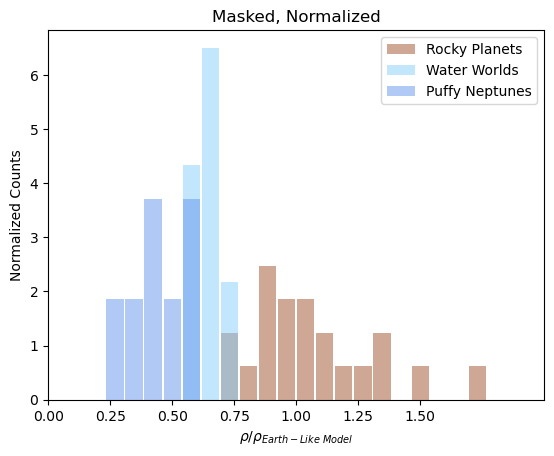

In [243]:
bins  = np.linspace(0, 3, 40)
###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,2)


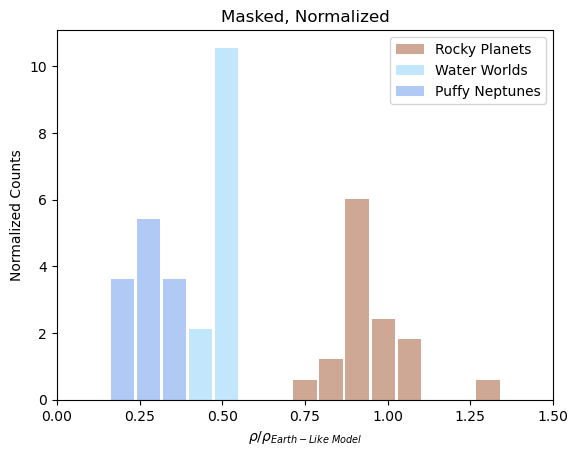

(0.0, 1.5)

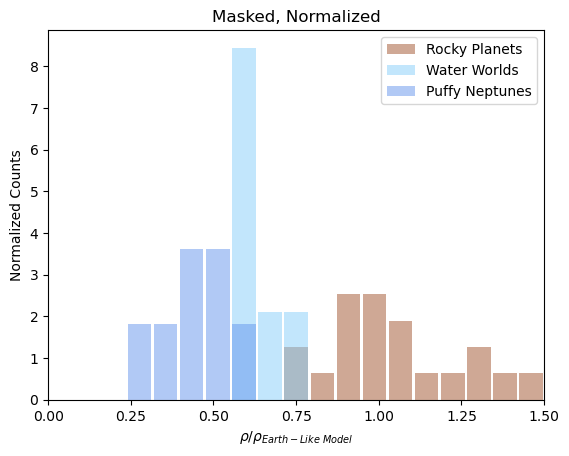

In [268]:
bins  = np.linspace(0, 1.5, 20)
pbins = np.linspace(0, 1.5, 100)
###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.show()
bins  = np.linspace(0, 1.5, 20)
pbins = np.linspace(0, 1.5, 100)
###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_rocky/earth_density, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
plt.hist(density_water/earth_density, bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True,label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_puffy/earth_density, bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Puffy Neptunes")

##### Plotting ######
plt.title('Masked, Normalized')
plt.ylabel('Normalized Counts')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xticks([0.0,0.25,0.5,0.75,1,1.25,1.5],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)



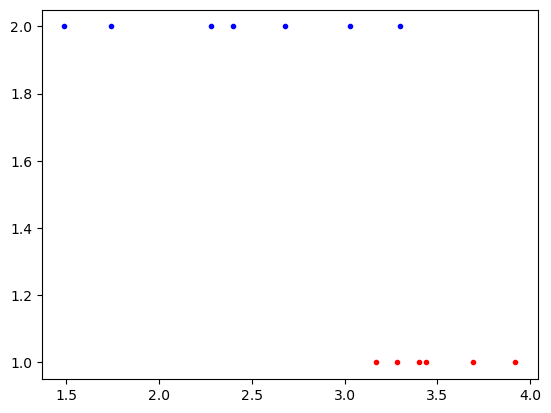

In [252]:
plt.plot()

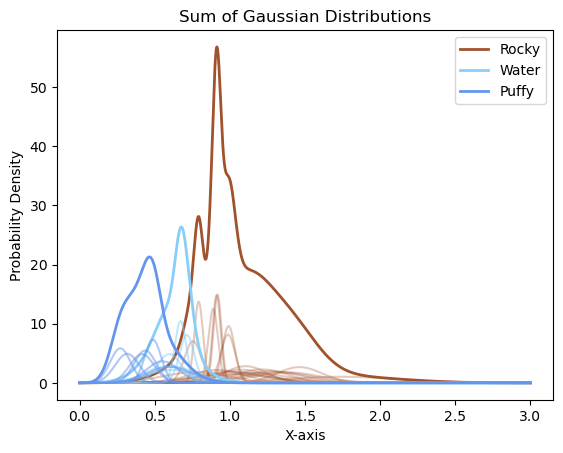

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(0, 3, 100000)
y_total = 0
for i in range(0,len(planet_rocky)):
    mu, sigma = density_rocky[i]/earth_density, (density_up_rocky[i]/earth_density + density_low_rocky[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y,"Sienna",alpha = 0.3)
    y_total += y
plt.plot(x, y_total, label='Rocky', linestyle='-', linewidth=2,color= "Sienna")

y_total = 0
for i in range(0,len(planet_water)):
    mu, sigma = density_water[i]/earth_density, (density_up_water[i]/earth_density + density_low_water[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma,)
    plt.plot(x, y,color = "lightskyblue",alpha = 0.5)
    y_total += y
plt.plot(x, y_total, label='Water', linestyle='-', linewidth=2,color= "lightskyblue")

y_total = 0
for i in range(0,len(planet_puffy)):
    mu, sigma = density_puffy[i]/earth_density, (density_up_puffy[i]/earth_density + density_low_puffy[i]/earth_density)/2
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y,"Cornflowerblue",alpha = 0.5,linestyle = "solid")
    y_total += y
plt.plot(x, y_total, label='Puffy', linestyle='-', linewidth=2,color= "Cornflowerblue")

plt.title('Sum of Gaussian Distributions')
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Area under the curve: 0.9999999999999977


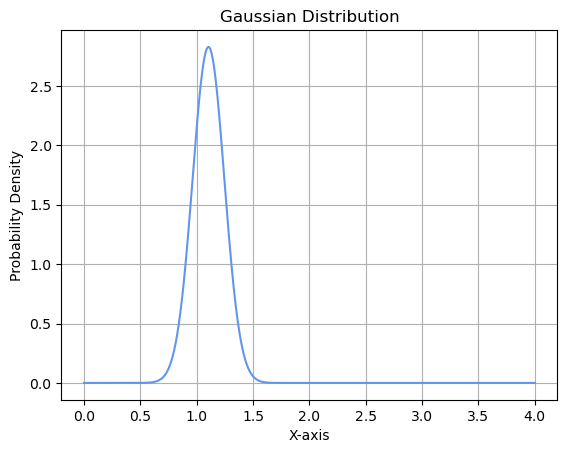

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps

x = np.linspace(0, 4, 10000)

i = 1
mu = density_rocky[i] / earth_density
sigma = (density_up_rocky[i] / earth_density + density_low_rocky[i] / earth_density) / 2
y = norm.pdf(x, mu, sigma)
plt.plot(x, y, color="Cornflowerblue")
area_under_curve = simps(y, x)
print("Area under the curve:", area_under_curve)

# Customize the plot
plt.title('Gaussian Distribution')
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.grid(True)

# Show the plot
plt.show()


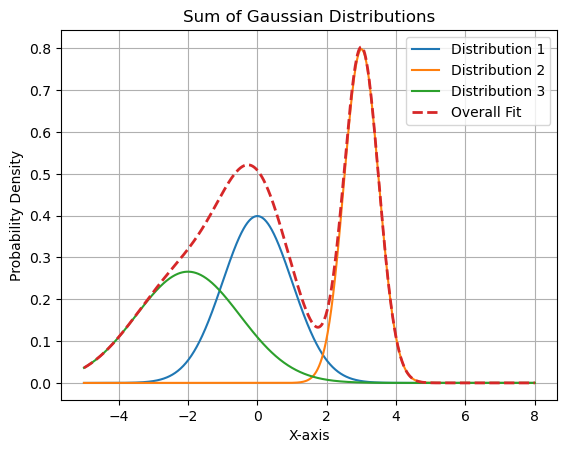

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the parameters for each Gaussian distribution
mu1, sigma1 = 0, 1
mu2, sigma2 = 3, 0.5
mu3, sigma3 = -2, 1.5

# Generate data points for each distribution
x = np.linspace(-5, 8, 1000)
y1 = norm.pdf(x, mu1, sigma1)
y2 = norm.pdf(x, mu2, sigma2)
y3 = norm.pdf(x, mu3, sigma3)

# Add the distributions together to create the overall fit
y_total = y1 + y2 + y3

# Plot each individual distribution and the overall fit
plt.plot(x, y1, label='Distribution 1')
plt.plot(x, y2, label='Distribution 2')
plt.plot(x, y3, label='Distribution 3')
plt.plot(x, y_total, label='Overall Fit', linestyle='--', linewidth=2)

# Customize the plot
plt.title('Sum of Gaussian Distributions')
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

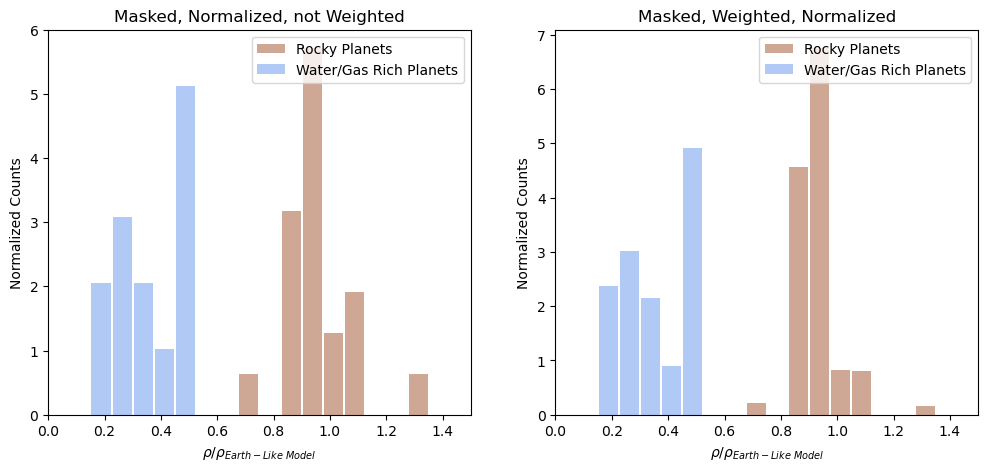

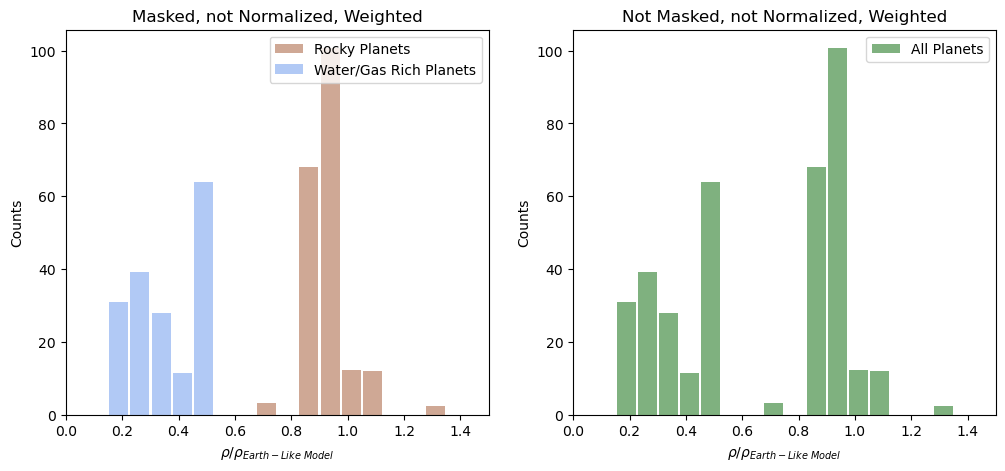

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True,label = "Rocky Planets")

##### Puffy Neptunes + Water Worlds ####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Rocky Planets")

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_NO_Gauss1.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Water/Gas Rich Planets")

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "All Planets")
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_NO_Gauss2.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


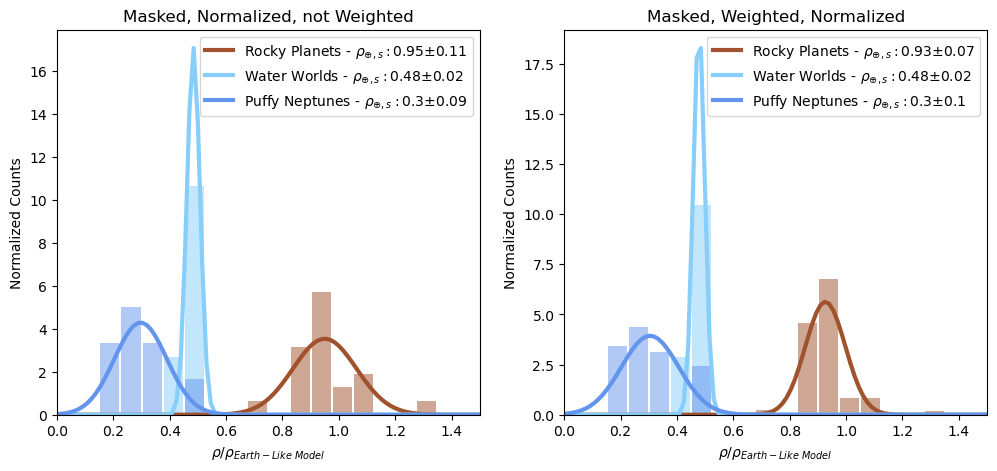

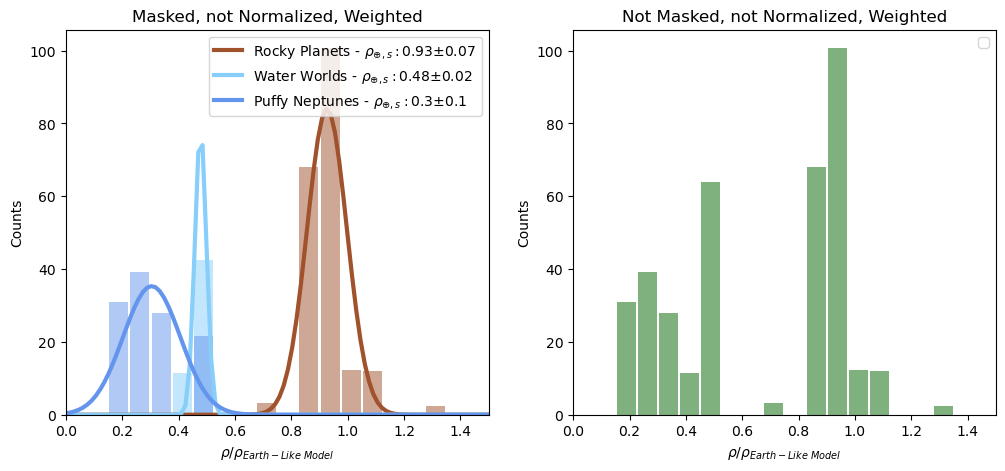

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_3pop_Gauss1.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
rocky_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
water_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
puffy_scale  = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight)
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_3pop_Gauss2.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


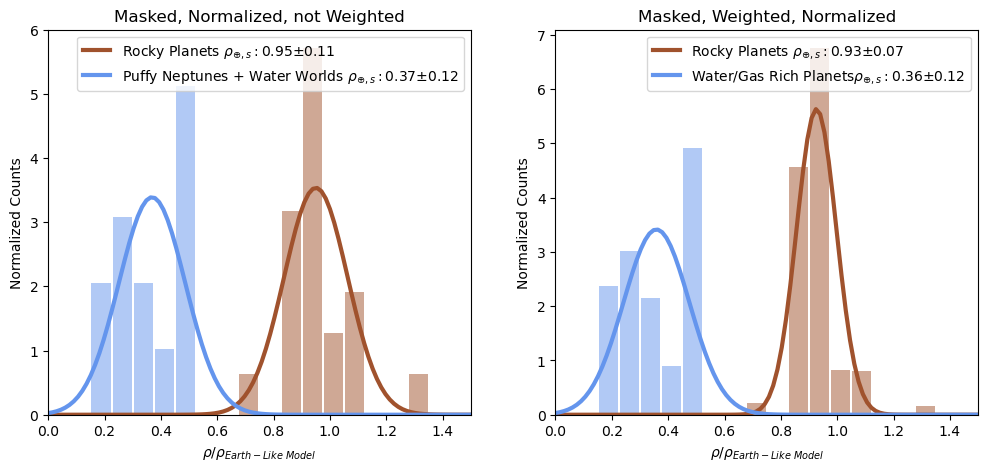

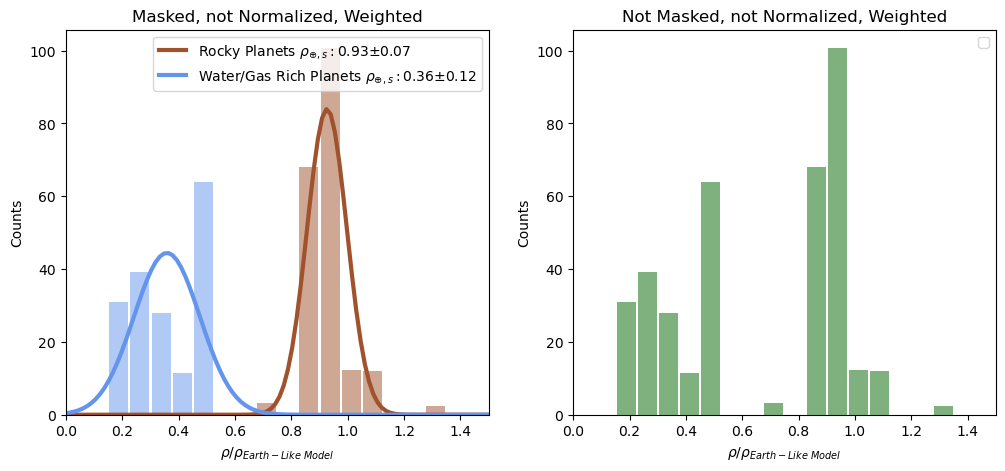

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
bins  = np.linspace(0, 1.5, 21)
pbins = np.linspace(0, 1.5, 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

###### Rocky Planets #####
indexs  = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Puffy Neptunes + Water Worlds ####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5,rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes + Water Worlds "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Normalized, not Weighted')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)
###### Rocky Planets #####
indexs  = index_rocky
weight  = weight_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water/Gas Rich Planets"+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, Weighted, Normalized')
plt.ylabel('Normalized Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_2pop_Gauss1.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Puffy Neptunes #####
indexs  = np.concatenate([index_water, index_puffy])
weight  = np.concatenate([weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water/Gas Rich Planets "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)


plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_norm[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight)
plt.title('Not Masked, not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)
image_name = 'LIV34_Histograms_2pop_Gauss2.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


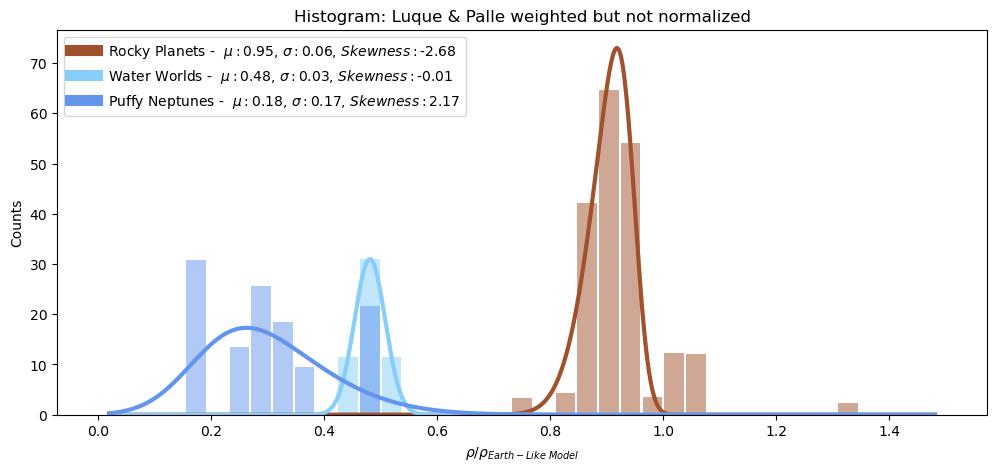

In [13]:
# Define a function for skewed Gaussian fitting
def skewed_gaussian(x, amplitude, mean, stddev, skew):
    return amplitude * skewnorm.pdf(x, skew, loc=mean, scale=stddev)

# Define a function for plotting histograms with skewed Gaussian fits
def plot_skewed_gaussian(data, weights, label, color, bins, title):
    hist, bin_edges = np.histogram(data, bins=bins, weights=weights, density=False)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    initial_params = [1.0, np.mean(data), np.std(data), 0.0]  # Adjust initial parameters
    params, _ = curve_fit(skewed_gaussian, bin_centers, hist, p0=initial_params)
    amplitude, mean, stddev, skew = params

    x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y_fit = skewed_gaussian(x_fit, amplitude, mean, stddev, skew)

    plt.hist(data, bins=bins, color=color, alpha=0.5, rwidth=0.9, density=False, weights=weights)
    plt.plot(x_fit, y_fit, label=label + "  $μ:$" + f"{mean:.2f}, $σ:$" + f"{stddev:.2f}, $Skewness:$" + f"{skew:.2f}", color=color, linewidth=3)

    plt.title(title)
    plt.legend(loc='upper right')

    for line in plt.legend().get_lines():
        line.set_linewidth(8.0)

    plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
    plt.ylabel('Counts')

# Define your data and weights


fig, ax = plt.subplots(figsize=(12,5))

bins = np.linspace(0, 1.5, 40)
data_rocky = density_norm[index_rocky]
weights_rocky = weight_rocky
data_water = density_norm[index_water]
weights_water = weight_water
data_puffy = density_norm[index_puffy]
weights_puffy = weight_puffy

plot_skewed_gaussian(data_rocky, weights_rocky, "Rocky Planets -", "sienna", bins, "")
plot_skewed_gaussian(data_water, weights_water, "Water Worlds -", "lightskyblue", bins, '')
plot_skewed_gaussian(data_puffy, weights_puffy, "Puffy Neptunes -", "cornflowerblue", bins, 'Histogram: Luque & Palle weighted but not normalized')
image_name = 'LIV34_Histograms_3pop_skew.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

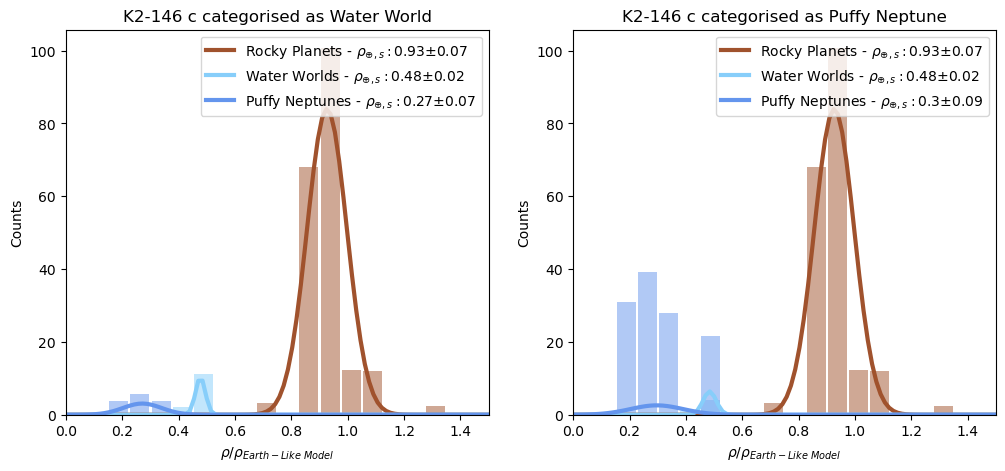

In [14]:
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('K2-146 c categorised as Water World')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_norm[indexs], aweights = weight, ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('K2-146 c categorised as Puffy Neptune')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_Histograms_K2-146_importance.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

## Recreating Luque & Palle histogram

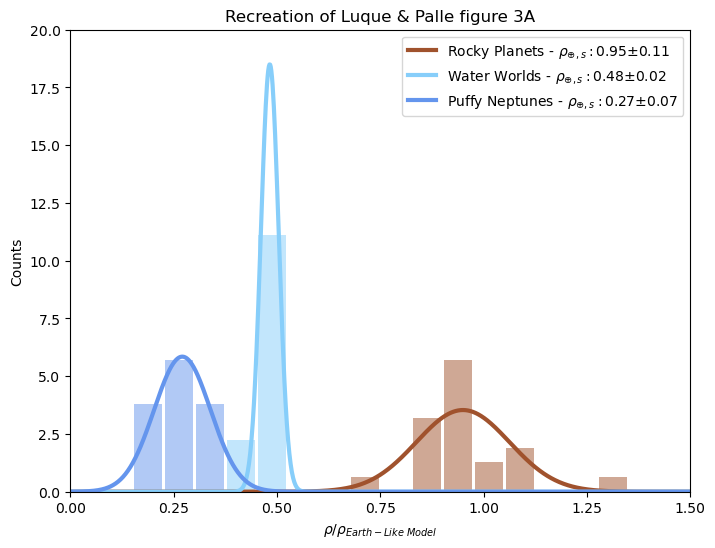

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 

index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) and planet_name_LI[i] != 'K2-146 c':
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])) or planet_name_LI[i] == 'K2-146 c':
            index_water.append(i)
weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

bins  = np.linspace(0, 1.5, num= 21)
pbins = np.linspace(0, 1.5, 1000)
###### Rocky Planets #####
indexs = index_rocky
plt.hist(density_norm[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_rocky = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
plt.hist(density_norm[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_water = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
plt.hist(density_norm[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True)
mu = np.average(density_norm[indexs])
sigma = np.sqrt(np.cov(density_norm[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
scale_puffy = scale_factor
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Recreation of Luque & Palle figure 3A')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.ylim(0,20)
plt.xticks([0,0.25,0.5,0.75,1,1.25,1.50],["0.00","0.25","0.50","0.75","1.00","1.25","1.50"],minor=False)

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
image_name = 'luque_scale_factor.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

## Adding planets to the sample

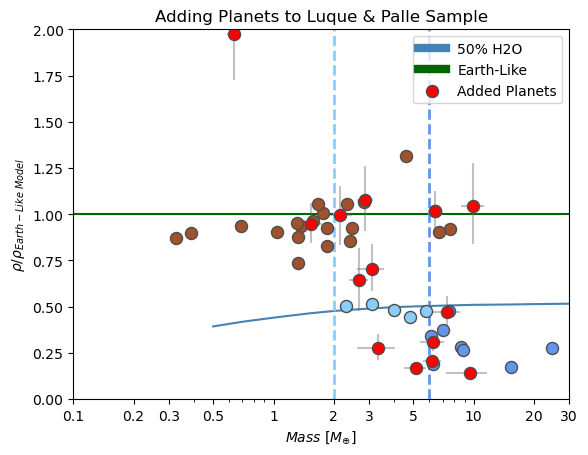

In [220]:
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

xerr = [np.abs(mass_low2), mass_up2]
yerr = [np.abs(density_low2) / np.array(rocky_density(mass2)) , density_up2 / np.array(rocky_density(mass2)) ]
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")
plt.errorbar(mass2, np.array(density2)/ np.array(rocky_density(mass2)), xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

image_name = 'LIV34_add_DM1.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

NameError: name 'planet_name' is not defined

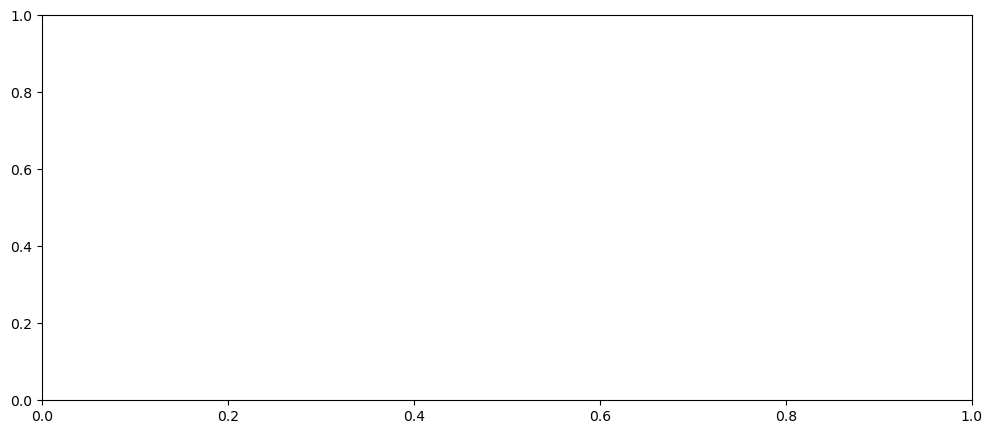

In [221]:
fig, ax = plt.subplots(figsize=(12,5))
masses_add  = np.concatenate([mass_LI[index],mass2])
radii_add   = np.concatenate([radius_LI[index],radius2])
density_add = np.concatenate([density_norm[index],np.array(density2) / np.array(rocky_density(mass2))])
selected_planets = [planet_name_LI[i] for i in index if i < len(planet_name)]
planet_name = np.concatenate([selected_planets,planet2])
xerr = [np.concatenate([mass_err_LI[0][index],np.abs(mass_low2)]), np.concatenate([mass_err_LI[1][index],np.abs(mass_up2)])]
yerr = [np.concatenate([density_err_LI[0][index],np.abs(density_low2/ np.array(rocky_density(mass2)))]) , np.concatenate([density_err_LI[1][index], np.abs(density_up2/ np.array(rocky_density(mass2))) ])]
no_plot = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] not in planets:
        no_plot.append(planet_name_LI[i])
        
index_puffy = []; index_water = []; index_rocky = []    
for i in range(0, len(planet_name)):
    if radii_add[i] < 4 and planet_name[i] not in no_plot:
        if planet_name[i] in planets or planet_name[i] in planet2:
            if abs(1- density_add[i]) < abs(density_add[i] - h20model_density(masses_add[i])):
                index_rocky.append(i)
            if masses_add[i] >= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_puffy.append(i)
            if 2 <= masses_add[i] <= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_water.append(i)

weight = 1/(yerr[0]**2 +yerr[1]**2 )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "red",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),facecolor = "None",s=75, edgecolor = "red",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
    
image_name = 'LIV34_add_DM.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Luque & Palle Sample")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,radius2,xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(radius_low2),np.abs(radius_up2)],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")
norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(temps)):
    if planet_name[i] in planets or planet_name[i] in planet2:
        plt.scatter(masses_add[i], radii_add[i], c=[temps[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Planets added to Luque & Palle Sample")
image_name = 'LIV34_add_RM.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_add[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "Water Worlds")

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight, label = "Puffy Neptunes")

##### Plotting ######
plt.title('Added planets: Weighted, Not Normalized')
plt.ylabel('Counts')

plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*255
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water Worlds #####
indexs  = index_water
weight  = weight_water
plt.hist(density_add[indexs], bins=bins, color='lightskyblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*130
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

##### Puffy Neptunes #####
indexs  = index_puffy
weight  = weight_puffy
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*240
plt.plot(pbins, best_fit_line,label ="Puffy Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Added planets: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "All Planets")
plt.title('Planets added: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

image_name = 'LIV34_add_hist3pop.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Rocky Planets")

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "Puffy/ Gas Rich Worlds")

##### Plotting ######
plt.title('Added planets: Weighted, Not Normalized')
plt.ylabel('Counts')

leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 2)  # 1 row, 2 columns, first subplot
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*255
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=False, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*391
plt.plot(pbins, best_fit_line,label ="Puffy/ Gas Rich Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)

##### Plotting ######
plt.title('Added planets: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
plt.legend(loc='upper right')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

plt.subplot(1, 3, 3)  # 1 row, 2 columns, first subplot

###### Rocky Planets #####
indexs  = np.concatenate([index_rocky,index_water, index_puffy])
weight  = np.concatenate([weight_rocky,weight_water, weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='darkgreen', alpha=0.5, rwidth=0.9, density=False, weights=weight,label = "All Planets")
plt.title('Planets added: not Normalized, Weighted')
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel('Counts')
plt.xlim(0,1.50)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.xlim(0,1.50)

indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])

image_name = 'LIV34_add_hist2pop.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
###### Rocky Planets #####
indexs = index_rocky
weight = weight_rocky
bins  = np.linspace(0, 1.5, 21)
plt.hist(density_add[indexs], bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, density=True, weights=weight)
mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "Sienna",linewidth=3)

##### Water/Puffy Worlds #####
indexs  = np.concatenate([index_water,index_puffy])
weight  = np.concatenate([weight_water,weight_puffy])
plt.hist(density_add[indexs], bins=bins, color='cornflowerblue', alpha=0.5, rwidth=0.9, density=True, weights=weight)

mu = np.average(density_add[indexs],weights = weight)
sigma = np.sqrt(np.cov(density_add[indexs], aweights = weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy/ Gas Rich Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3)


In [ ]:
hist_counts = plt.hist(density_add[indexs], bins=bins, weights=weight,density=True)
hist_counts2 = plt.hist(density_add[indexs], bins=bins, weights=weight,density=False)


In [ ]:
hist_counts[1][1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code
indexs = index_rocky
weight = weight_rocky
bins = np.linspace(0, 1.5, 21)
density_values = density_add[indexs]

# Get the raw counts before normalization
raw_counts, bin_edges = np.histogram(density_values, bins=bins, weights=weight)
normalized_counts, bin_edges = np.histogram(density_values, bins=bins, density=True, weights=weight)
scale_factor = sum(raw_counts)/sum(normalized_counts)
# Plot the histogram with raw counts
plt.hist(density_values, bins=bins, color='Sienna', alpha=0.5, rwidth=0.9, weights=weight, label='Raw Counts')

mu = np.average(density_values, weights=weight)
sigma = np.sqrt(np.cov(density_values, aweights=weight, ddof=0))
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line, label="Rocky Planets - " + "$ρ_{⊕,s}:$" + str(np.round(mu, 2)) + "±" + str(np.round(sigma, 2)))

# Get the normalized counts
normalized_counts, bin_edges = np.histogram(density_values, bins=bins, density=True, weights=weight)

# Print or use the raw and normalized counts for further analysis
print("Raw Counts:", raw_counts)
print("Normalized Counts:", normalized_counts)

# Show the plot
plt.legend()
plt.show()

In [ ]:
normalized_counts[12]

In [ ]:
sum(raw_counts)/sum(normalized_counts)